In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = '/Users/somyasharma/Desktop/college_stuff/1 Pattern Recognition/PR_final/Pattern_Recognition/HW4/lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


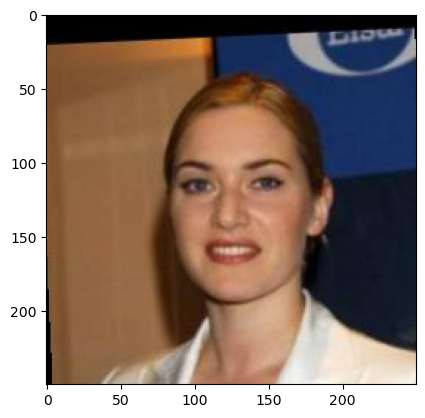

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

# Differences in Terms of Applications:
AutoEncoders (AE): Primarily used for dimensionality reduction, feature learning, and data denoising. The latent space does not have a specific structure or distribution.
Variational AutoEncoders (VAE): Specifically designed for generating new data points. Introduces a probabilistic approach, modeling the latent space as a probability distribution. This allows generating new samples by sampling from the distribution.
# Differences in Terms of Architecture:
AutoEncoders (AE): The encoder directly maps input data to a fixed-size latent representation. Deterministic: Given the same input, AE will produce the same latent representation.
Variational AutoEncoders (VAE): The encoder maps input data to the parameters of a probability distribution (usually Gaussian) in the latent space. Stochastic: The sampling from the distribution introduces randomness, leading to a continuous and structured latent space.
# Differences in Terms of Loss Function:
AutoEncoders (AE): Typically use Mean Squared Error (MSE) loss between the input and the reconstructed output. Reconstruction loss focuses on getting a faithful reconstruction of the input.
Variational AutoEncoders (VAE): Use a combination of two terms in the loss function: reconstruction loss and KL divergence. Reconstruction loss ensures faithful reconstruction. KL divergence encourages the learned distribution to be close to a predefined distribution (often a standard Gaussian), enforcing a more structured latent space.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE,self).__init__()  
        self.encoded_images = self.encoder()
        self.decoded_images = self.decoder()
        
    def encoder(self):

            return nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), 
                                 nn.BatchNorm2d(8),  
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2),  
                                 
                                 nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), 
                                 nn.BatchNorm2d(16), 
                                 nn.ReLU(True),
                                 nn.MaxPool2d(2, stride=2),
                                 
                                 nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                                 nn.BatchNorm2d(32), 
                                 nn.ReLU(True), 
                                 nn.MaxPool2d(2, stride=2) 
                                ) 
            

    # out =(in −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1 
    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(16),
                             
                             nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(8),
                             
                             nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                             nn.Tanh()
                            )
        
    def forward(self,x):
        encoded_images = self.encoded_images(x)
        mu_f, logvar_f = encoded_images.split(encoded_images.size(1)//2, 1)
        std_f = torch.exp(0.5 * logvar_f)
        encoded_images = torch.randn_like(mu_f) * std_f + mu_f
        decoded_images = self.decoded_images(encoded_images)
        return decoded_images
    # Dummy image, tensor replaces this with the actual image tensor
testing_image = torch.randn(1, 3, 250, 250)

# Forward pass through the model
with torch.no_grad():
    encoded_output, decoded_output, mu, log_var = model.forward(testing_image)

# Print the shape of the output of the encoder
print("Shape of the output of the encoder:", encoded_output.shape)

# Print the shape of the output of the decoder
print("Shape of the output of the decoder:", decoded_output.shape)
       

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [ ]:
# Dummy image tensor (replace this with your actual image tensor)
testing_image = torch.randn(1, 3, 250, 250)

# Forward pass through the model
with torch.no_grad():
    encoded_output, decoded_output, mu, log_var = model.forward(testing_image)

# To Print the shape of output that we get via encoder
print("Shape of the output of the encoder:", encoded_output.shape)

# To Print the shape of output that we get via decoder
print("Shape of the output of the decoder:", decoded_output.shape)

Generating new samples in the latent space involves sampling from the learned distribution within the latent space, as defined by the mean (mu) and log variance (logvar) obtained from the encoder in a Variational AutoEncoder (VAE).

Here are the steps to generate new samples:

1. **Sampling from the Latent Space:**
   - Use the reparameterization trick to sample from a normal distribution using the mean (mu) and standard deviation (std) derived from the encoder's output. The standard deviation is calculated as `std = exp(0.5 * logvar)`. Then, generate random samples (`eps`) from a standard normal distribution and calculate the latent variable (`z`) as `z = mu + eps * std`.

   ```python
   def reparameterize(mu, logvar):
       std = torch.exp(0.5 * logvar)
       eps = torch.randn_like(std)
       return mu + eps * std
   ```

2. **Generating New Samples:**
   - Pass the sampled latent variable (`z`) through the decoder to generate new samples. The decoder takes the latent variable and transforms it back into the data space.

   ```python
   latent_samples = reparameterize(mu, logvar)
   generated_images = model.decoder(latent_samples)
   ```

   The `generated_images` now represent new samples that are generated in the latent space and then transformed into the data space by the decoder.

3. **Interpretation:**
   - The reparameterization trick introduces a stochastic element during sampling, ensuring that the latent space has a continuous and structured distribution. By varying the sampled latent variables, you explore different regions of the latent space, generating diverse and novel samples.

Generating new samples in the latent space involves incorporating randomness through the reparameterization trick and using the decoder to transform these latent samples into meaningful data space representations. This process allows the VAE to generate diverse and realistic samples by exploring different regions of the latent distribution.

1. **Learning the Latent Space:**
   - During the training of the VAE, the encoder part of the network learns to map input data to a distribution in the latent space. This distribution is typically modeled as a Gaussian distribution with a mean (\(\mu\)) and log variance (\(\log(\sigma^2)\)).

2. **Reparameterization Trick:**
   - To generate new samples, we use a technique called the reparameterization trick. Instead of directly sampling from the distribution defined by \(\mu\) and \(\log(\sigma^2)\), we sample from a standard normal distribution (\(N(0, 1)\)) and transform the samples to match the learned distribution. This is done using the formula:
     \[ z = \mu + \sigma \cdot \epsilon \]
     where \(\epsilon\) is a sample from \(N(0, 1)\). This trick makes the model differentiable, enabling backpropagation during training.

3. **Generating New Samples:**
   - During the generation phase (not training), we sample random values from the standard normal distribution and use the learned \(\mu\) and \(\sigma\) to transform them into points in the latent space.

4. **Decoding to Data Space:**
   - These sampled points (\(z\)) are then passed through the decoder part of the network. The decoder reconstructs the original data from these points in the latent space.

5. **Interpretation:**
   - By sampling different points in the latent space and decoding them, we generate new data samples. The VAE's ability to generate diverse samples comes from the stochasticity introduced during the reparameterization, allowing us to explore various regions of the learned latent distribution.

Also, generating new samples in the latent space involves navigating the structured latent space learned by the VAE, introducing randomness through the reparameterization trick, and finally decoding these samples to obtain novel and diverse data points.

In [7]:
model = VAE()

In [8]:
for x,y in dataloader:
## forward
    output_encoder = model.encoded_images(x)
    print(output_encoder.shape)
    mu_f, logvar_f = output_encoder.split(output_encoder.size(1)//2, 1)
    std_f = torch.exp(0.5 * logvar_f)
    output_encoder = torch.randn_like(mu_f) * std_f + mu_f
    output_decoder = model.decoded_images(output_encoder)
    
    print(output_decoder.shape)
    output_vae = model.forward(x)
    print(output_vae.shape)
    break

torch.Size([32, 32, 32, 32])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [9]:
total_parameters = sum(params.numel() for params in model.parameters())
print(total_parameters)

9891


* create an optimizer for training

In [10]:
optim = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=1e-5)

In [11]:
loss_function = nn.MSELoss()

In [12]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')

def to_img(x):
    x = x.view(x.size(0), 3, 250, 250)
    return x

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

If the loss in your training process is not decreasing as expected, it's crucial to troubleshoot and identify potential issues. Here are some steps you can take:

Check Learning Rate:
If the learning rate is too high, the model might oscillate or overshoot the minimum. Conversely, if it's too low, the training might be slow, and the model might get stuck in local minima. Experiment with different learning rates to find an optimal value.
Evaluate Model Complexity:
The model might be too simple or too complex for the given task. If it's too simple, it may struggle to capture the underlying patterns. If it's too complex, it might overfit the training data. Adjust the model architecture and complexity accordingly.
Increase Training Epochs:
It's possible that the model needs more training epochs to converge. If the loss is not decreasing, training for additional epochs might allow the model to continue learning. Monitor the loss over an extended period.
Inspect Data Preprocessing:
Incorrect or inadequate data preprocessing can impact training. Ensure that data normalization, scaling, and other preprocessing steps are applied correctly. Check for outliers and anomalies in the dataset.
Verify Loss Function:
Ensure that the chosen loss function is appropriate for the task. For example, if working with a regression problem, Mean Squared Error (MSE) might be suitable, while for classification, Cross-Entropy loss is common.
Check for Overfitting:
Overfitting can occur if the model memorizes the training data without generalizing well to unseen data. Introduce regularization techniques such as dropout or weight decay to prevent overfitting.
Explore Different Optimizers:
Different optimization algorithms might behave differently on your specific task. Experiment with alternative optimizers, such as Adam, SGD, or RMSprop, to see if they yield better results.
Inspect Model Initialization:
Poor initialization of model weights can hinder convergence. Ensure that the model parameters are initialized appropriately. Techniques like Xavier/Glorot initialization are commonly used.
Monitor Loss Components:
If your model has multiple components in the loss function (e.g., reconstruction loss and KL divergence for VAE), monitor each component separately. This can help identify which part of the loss is not decreasing.
Debug Gradual Changes:
Gradually introduce changes to your model or training setup and monitor the effects. This helps pinpoint specific factors contributing to the loss behavior.

In [13]:
mu_f, logvar_f = output_encoder.split(output_encoder.size(1)//2,1)
print(mu_f.shape)

torch.Size([32, 8, 32, 32])


In [ ]:
for epoch in range(100):
    total_loss = 0
    i=0
    for img,y in dataloader:
        # forward

        param_f = model.encoded_images(img)
        mu_f, logvar_f = param_f.split(param_f.size(1)//2, 1)
        std_f = torch.exp(0.5 * logvar_f)
        z = torch.randn_like(mu_f) * std_f + mu_f
        
        kl = - 0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp()) 
        kl_loss = kl.sum() / img.size(0)
        
        output = model.decoded_images(z)
        loss = loss_function(output,img)
        loss += kl_loss
        
        
        # backward
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        print("epoch ", epoch," batch ",i," loss ",loss)
        i = i+1
    # logs
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, 100, total_loss))

epoch  0  batch  0  loss  tensor(17472.0098, grad_fn=<AddBackward0>)
epoch  0  batch  1  loss  tensor(14830.7021, grad_fn=<AddBackward0>)
epoch  0  batch  2  loss  tensor(12685.4863, grad_fn=<AddBackward0>)
epoch  0  batch  3  loss  tensor(11541.4551, grad_fn=<AddBackward0>)
epoch  0  batch  4  loss  tensor(10723.3340, grad_fn=<AddBackward0>)
epoch  0  batch  5  loss  tensor(9812.1055, grad_fn=<AddBackward0>)
epoch  0  batch  6  loss  tensor(8981.1855, grad_fn=<AddBackward0>)
epoch  0  batch  7  loss  tensor(8733.5186, grad_fn=<AddBackward0>)
epoch  0  batch  8  loss  tensor(8248.2422, grad_fn=<AddBackward0>)
epoch  0  batch  9  loss  tensor(7630.1074, grad_fn=<AddBackward0>)
epoch  0  batch  10  loss  tensor(7464.9204, grad_fn=<AddBackward0>)
epoch  0  batch  11  loss  tensor(7145.2847, grad_fn=<AddBackward0>)
epoch  0  batch  12  loss  tensor(7028.6709, grad_fn=<AddBackward0>)
epoch  0  batch  13  loss  tensor(6467.2686, grad_fn=<AddBackward0>)
epoch  0  batch  14  loss  tensor(6411.

epoch  0  batch  119  loss  tensor(1902.6267, grad_fn=<AddBackward0>)
epoch  0  batch  120  loss  tensor(1709.9154, grad_fn=<AddBackward0>)
epoch  0  batch  121  loss  tensor(1789.0023, grad_fn=<AddBackward0>)
epoch  0  batch  122  loss  tensor(1833.2760, grad_fn=<AddBackward0>)
epoch  0  batch  123  loss  tensor(1801.5952, grad_fn=<AddBackward0>)
epoch  0  batch  124  loss  tensor(1795.6621, grad_fn=<AddBackward0>)
epoch  0  batch  125  loss  tensor(1832.2941, grad_fn=<AddBackward0>)
epoch  0  batch  126  loss  tensor(1696.2606, grad_fn=<AddBackward0>)
epoch  0  batch  127  loss  tensor(1695.1393, grad_fn=<AddBackward0>)
epoch  0  batch  128  loss  tensor(1681.5472, grad_fn=<AddBackward0>)
epoch  0  batch  129  loss  tensor(1655.1333, grad_fn=<AddBackward0>)
epoch  0  batch  130  loss  tensor(1668.7921, grad_fn=<AddBackward0>)
epoch  0  batch  131  loss  tensor(1795.8944, grad_fn=<AddBackward0>)
epoch  0  batch  132  loss  tensor(1712.0773, grad_fn=<AddBackward0>)
epoch  0  batch  133

epoch  0  batch  237  loss  tensor(731.7927, grad_fn=<AddBackward0>)
epoch  0  batch  238  loss  tensor(777.5319, grad_fn=<AddBackward0>)
epoch  0  batch  239  loss  tensor(794.9918, grad_fn=<AddBackward0>)
epoch  0  batch  240  loss  tensor(729.0894, grad_fn=<AddBackward0>)
epoch  0  batch  241  loss  tensor(743.5171, grad_fn=<AddBackward0>)
epoch  0  batch  242  loss  tensor(707.1451, grad_fn=<AddBackward0>)
epoch  0  batch  243  loss  tensor(731.1139, grad_fn=<AddBackward0>)
epoch  0  batch  244  loss  tensor(795.4767, grad_fn=<AddBackward0>)
epoch  0  batch  245  loss  tensor(788.5951, grad_fn=<AddBackward0>)
epoch  0  batch  246  loss  tensor(733.8497, grad_fn=<AddBackward0>)
epoch  0  batch  247  loss  tensor(798.3601, grad_fn=<AddBackward0>)
epoch  0  batch  248  loss  tensor(715.5913, grad_fn=<AddBackward0>)
epoch  0  batch  249  loss  tensor(748.2258, grad_fn=<AddBackward0>)
epoch  0  batch  250  loss  tensor(723.0584, grad_fn=<AddBackward0>)
epoch  0  batch  251  loss  tensor

epoch  0  batch  356  loss  tensor(335.7712, grad_fn=<AddBackward0>)
epoch  0  batch  357  loss  tensor(341.0003, grad_fn=<AddBackward0>)
epoch  0  batch  358  loss  tensor(338.1331, grad_fn=<AddBackward0>)
epoch  0  batch  359  loss  tensor(339.6974, grad_fn=<AddBackward0>)
epoch  0  batch  360  loss  tensor(303.4608, grad_fn=<AddBackward0>)
epoch  0  batch  361  loss  tensor(267.3463, grad_fn=<AddBackward0>)
epoch  0  batch  362  loss  tensor(340.1385, grad_fn=<AddBackward0>)
epoch  0  batch  363  loss  tensor(292.2149, grad_fn=<AddBackward0>)
epoch  0  batch  364  loss  tensor(349.1254, grad_fn=<AddBackward0>)
epoch  0  batch  365  loss  tensor(298.2785, grad_fn=<AddBackward0>)
epoch  0  batch  366  loss  tensor(318.5885, grad_fn=<AddBackward0>)
epoch  0  batch  367  loss  tensor(254.2822, grad_fn=<AddBackward0>)
epoch  0  batch  368  loss  tensor(314.4489, grad_fn=<AddBackward0>)
epoch  0  batch  369  loss  tensor(285.1714, grad_fn=<AddBackward0>)
epoch  0  batch  370  loss  tensor

epoch  1  batch  62  loss  tensor(156.0654, grad_fn=<AddBackward0>)
epoch  1  batch  63  loss  tensor(134.9075, grad_fn=<AddBackward0>)
epoch  1  batch  64  loss  tensor(151.1609, grad_fn=<AddBackward0>)
epoch  1  batch  65  loss  tensor(107.4185, grad_fn=<AddBackward0>)
epoch  1  batch  66  loss  tensor(122.3466, grad_fn=<AddBackward0>)
epoch  1  batch  67  loss  tensor(155.5103, grad_fn=<AddBackward0>)
epoch  1  batch  68  loss  tensor(133.6392, grad_fn=<AddBackward0>)
epoch  1  batch  69  loss  tensor(149.3484, grad_fn=<AddBackward0>)
epoch  1  batch  70  loss  tensor(162.7978, grad_fn=<AddBackward0>)
epoch  1  batch  71  loss  tensor(124.3253, grad_fn=<AddBackward0>)
epoch  1  batch  72  loss  tensor(150.7591, grad_fn=<AddBackward0>)
epoch  1  batch  73  loss  tensor(133.1445, grad_fn=<AddBackward0>)
epoch  1  batch  74  loss  tensor(139.9537, grad_fn=<AddBackward0>)
epoch  1  batch  75  loss  tensor(133.1877, grad_fn=<AddBackward0>)
epoch  1  batch  76  loss  tensor(119.4820, grad

epoch  1  batch  183  loss  tensor(67.0593, grad_fn=<AddBackward0>)
epoch  1  batch  184  loss  tensor(62.5900, grad_fn=<AddBackward0>)
epoch  1  batch  185  loss  tensor(61.7141, grad_fn=<AddBackward0>)
epoch  1  batch  186  loss  tensor(50.6915, grad_fn=<AddBackward0>)
epoch  1  batch  187  loss  tensor(51.2531, grad_fn=<AddBackward0>)
epoch  1  batch  188  loss  tensor(60.2645, grad_fn=<AddBackward0>)
epoch  1  batch  189  loss  tensor(78.1916, grad_fn=<AddBackward0>)
epoch  1  batch  190  loss  tensor(58.8708, grad_fn=<AddBackward0>)
epoch  1  batch  191  loss  tensor(60.9541, grad_fn=<AddBackward0>)
epoch  1  batch  192  loss  tensor(70.9245, grad_fn=<AddBackward0>)
epoch  1  batch  193  loss  tensor(85.1901, grad_fn=<AddBackward0>)
epoch  1  batch  194  loss  tensor(57.6890, grad_fn=<AddBackward0>)
epoch  1  batch  195  loss  tensor(56.0009, grad_fn=<AddBackward0>)
epoch  1  batch  196  loss  tensor(48.4839, grad_fn=<AddBackward0>)
epoch  1  batch  197  loss  tensor(33.1307, grad

epoch  1  batch  304  loss  tensor(28.6934, grad_fn=<AddBackward0>)
epoch  1  batch  305  loss  tensor(30.7762, grad_fn=<AddBackward0>)
epoch  1  batch  306  loss  tensor(35.3815, grad_fn=<AddBackward0>)
epoch  1  batch  307  loss  tensor(25.8917, grad_fn=<AddBackward0>)
epoch  1  batch  308  loss  tensor(37.7597, grad_fn=<AddBackward0>)
epoch  1  batch  309  loss  tensor(33.3362, grad_fn=<AddBackward0>)
epoch  1  batch  310  loss  tensor(36.5645, grad_fn=<AddBackward0>)
epoch  1  batch  311  loss  tensor(36.0645, grad_fn=<AddBackward0>)
epoch  1  batch  312  loss  tensor(31.8713, grad_fn=<AddBackward0>)
epoch  1  batch  313  loss  tensor(22.0683, grad_fn=<AddBackward0>)
epoch  1  batch  314  loss  tensor(40.0471, grad_fn=<AddBackward0>)
epoch  1  batch  315  loss  tensor(26.2990, grad_fn=<AddBackward0>)
epoch  1  batch  316  loss  tensor(16.8627, grad_fn=<AddBackward0>)
epoch  1  batch  317  loss  tensor(43.4323, grad_fn=<AddBackward0>)
epoch  1  batch  318  loss  tensor(21.9470, grad

epoch  2  batch  11  loss  tensor(15.3166, grad_fn=<AddBackward0>)
epoch  2  batch  12  loss  tensor(8.7921, grad_fn=<AddBackward0>)
epoch  2  batch  13  loss  tensor(17.7690, grad_fn=<AddBackward0>)
epoch  2  batch  14  loss  tensor(9.4308, grad_fn=<AddBackward0>)
epoch  2  batch  15  loss  tensor(11.9869, grad_fn=<AddBackward0>)
epoch  2  batch  16  loss  tensor(9.1149, grad_fn=<AddBackward0>)
epoch  2  batch  17  loss  tensor(15.6813, grad_fn=<AddBackward0>)
epoch  2  batch  18  loss  tensor(9.6906, grad_fn=<AddBackward0>)
epoch  2  batch  19  loss  tensor(8.3281, grad_fn=<AddBackward0>)
epoch  2  batch  20  loss  tensor(7.0595, grad_fn=<AddBackward0>)
epoch  2  batch  21  loss  tensor(13.7764, grad_fn=<AddBackward0>)
epoch  2  batch  22  loss  tensor(11.6581, grad_fn=<AddBackward0>)
epoch  2  batch  23  loss  tensor(12.6641, grad_fn=<AddBackward0>)
epoch  2  batch  24  loss  tensor(13.5387, grad_fn=<AddBackward0>)
epoch  2  batch  25  loss  tensor(6.7002, grad_fn=<AddBackward0>)
ep

epoch  2  batch  134  loss  tensor(4.5184, grad_fn=<AddBackward0>)
epoch  2  batch  135  loss  tensor(8.2495, grad_fn=<AddBackward0>)
epoch  2  batch  136  loss  tensor(6.9651, grad_fn=<AddBackward0>)
epoch  2  batch  137  loss  tensor(8.5368, grad_fn=<AddBackward0>)
epoch  2  batch  138  loss  tensor(8.1409, grad_fn=<AddBackward0>)
epoch  2  batch  139  loss  tensor(9.1825, grad_fn=<AddBackward0>)
epoch  2  batch  140  loss  tensor(9.8111, grad_fn=<AddBackward0>)
epoch  2  batch  141  loss  tensor(6.0603, grad_fn=<AddBackward0>)
epoch  2  batch  142  loss  tensor(4.5611, grad_fn=<AddBackward0>)
epoch  2  batch  143  loss  tensor(10.7106, grad_fn=<AddBackward0>)
epoch  2  batch  144  loss  tensor(4.2240, grad_fn=<AddBackward0>)
epoch  2  batch  145  loss  tensor(4.2162, grad_fn=<AddBackward0>)
epoch  2  batch  146  loss  tensor(6.1815, grad_fn=<AddBackward0>)
epoch  2  batch  147  loss  tensor(6.6379, grad_fn=<AddBackward0>)
epoch  2  batch  148  loss  tensor(7.2585, grad_fn=<AddBackwa

epoch  2  batch  257  loss  tensor(5.6899, grad_fn=<AddBackward0>)
epoch  2  batch  258  loss  tensor(6.1309, grad_fn=<AddBackward0>)
epoch  2  batch  259  loss  tensor(4.5528, grad_fn=<AddBackward0>)
epoch  2  batch  260  loss  tensor(2.2993, grad_fn=<AddBackward0>)
epoch  2  batch  261  loss  tensor(4.6920, grad_fn=<AddBackward0>)
epoch  2  batch  262  loss  tensor(2.6060, grad_fn=<AddBackward0>)
epoch  2  batch  263  loss  tensor(4.7840, grad_fn=<AddBackward0>)
epoch  2  batch  264  loss  tensor(3.7220, grad_fn=<AddBackward0>)
epoch  2  batch  265  loss  tensor(6.3080, grad_fn=<AddBackward0>)
epoch  2  batch  266  loss  tensor(3.2805, grad_fn=<AddBackward0>)
epoch  2  batch  267  loss  tensor(2.8884, grad_fn=<AddBackward0>)
epoch  2  batch  268  loss  tensor(3.0312, grad_fn=<AddBackward0>)
epoch  2  batch  269  loss  tensor(3.4383, grad_fn=<AddBackward0>)
epoch  2  batch  270  loss  tensor(3.2264, grad_fn=<AddBackward0>)
epoch  2  batch  271  loss  tensor(3.3524, grad_fn=<AddBackwar

epoch  2  batch  380  loss  tensor(1.5099, grad_fn=<AddBackward0>)
epoch  2  batch  381  loss  tensor(4.9776, grad_fn=<AddBackward0>)
epoch  2  batch  382  loss  tensor(9.5132, grad_fn=<AddBackward0>)
epoch  2  batch  383  loss  tensor(3.9015, grad_fn=<AddBackward0>)
epoch  2  batch  384  loss  tensor(1.6376, grad_fn=<AddBackward0>)
epoch  2  batch  385  loss  tensor(1.5517, grad_fn=<AddBackward0>)
epoch  2  batch  386  loss  tensor(3.8102, grad_fn=<AddBackward0>)
epoch  2  batch  387  loss  tensor(5.1762, grad_fn=<AddBackward0>)
epoch  2  batch  388  loss  tensor(0.9164, grad_fn=<AddBackward0>)
epoch  2  batch  389  loss  tensor(3.1628, grad_fn=<AddBackward0>)
epoch  2  batch  390  loss  tensor(2.8225, grad_fn=<AddBackward0>)
epoch  2  batch  391  loss  tensor(2.5194, grad_fn=<AddBackward0>)
epoch  2  batch  392  loss  tensor(3.4828, grad_fn=<AddBackward0>)
epoch  2  batch  393  loss  tensor(1.4369, grad_fn=<AddBackward0>)
epoch  2  batch  394  loss  tensor(3.8096, grad_fn=<AddBackwar

epoch  3  batch  90  loss  tensor(1.4579, grad_fn=<AddBackward0>)
epoch  3  batch  91  loss  tensor(1.3474, grad_fn=<AddBackward0>)
epoch  3  batch  92  loss  tensor(1.4298, grad_fn=<AddBackward0>)
epoch  3  batch  93  loss  tensor(1.7081, grad_fn=<AddBackward0>)
epoch  3  batch  94  loss  tensor(0.6254, grad_fn=<AddBackward0>)
epoch  3  batch  95  loss  tensor(3.3034, grad_fn=<AddBackward0>)
epoch  3  batch  96  loss  tensor(1.6444, grad_fn=<AddBackward0>)
epoch  3  batch  97  loss  tensor(0.9182, grad_fn=<AddBackward0>)
epoch  3  batch  98  loss  tensor(1.4904, grad_fn=<AddBackward0>)
epoch  3  batch  99  loss  tensor(2.8294, grad_fn=<AddBackward0>)
epoch  3  batch  100  loss  tensor(0.9663, grad_fn=<AddBackward0>)
epoch  3  batch  101  loss  tensor(2.9490, grad_fn=<AddBackward0>)
epoch  3  batch  102  loss  tensor(1.6728, grad_fn=<AddBackward0>)
epoch  3  batch  103  loss  tensor(0.9965, grad_fn=<AddBackward0>)
epoch  3  batch  104  loss  tensor(0.8799, grad_fn=<AddBackward0>)
epoch

epoch  3  batch  213  loss  tensor(0.7015, grad_fn=<AddBackward0>)
epoch  3  batch  214  loss  tensor(1.4743, grad_fn=<AddBackward0>)
epoch  3  batch  215  loss  tensor(1.2204, grad_fn=<AddBackward0>)
epoch  3  batch  216  loss  tensor(0.9645, grad_fn=<AddBackward0>)
epoch  3  batch  217  loss  tensor(1.7378, grad_fn=<AddBackward0>)
epoch  3  batch  218  loss  tensor(0.5019, grad_fn=<AddBackward0>)
epoch  3  batch  219  loss  tensor(1.2120, grad_fn=<AddBackward0>)
epoch  3  batch  220  loss  tensor(0.8616, grad_fn=<AddBackward0>)
epoch  3  batch  221  loss  tensor(1.3988, grad_fn=<AddBackward0>)
epoch  3  batch  222  loss  tensor(1.5081, grad_fn=<AddBackward0>)
epoch  3  batch  223  loss  tensor(1.0069, grad_fn=<AddBackward0>)
epoch  3  batch  224  loss  tensor(2.9094, grad_fn=<AddBackward0>)
epoch  3  batch  225  loss  tensor(0.6317, grad_fn=<AddBackward0>)
epoch  3  batch  226  loss  tensor(1.0469, grad_fn=<AddBackward0>)
epoch  3  batch  227  loss  tensor(0.7705, grad_fn=<AddBackwar

epoch  3  batch  336  loss  tensor(1.0947, grad_fn=<AddBackward0>)
epoch  3  batch  337  loss  tensor(0.4875, grad_fn=<AddBackward0>)
epoch  3  batch  338  loss  tensor(0.3624, grad_fn=<AddBackward0>)
epoch  3  batch  339  loss  tensor(0.6826, grad_fn=<AddBackward0>)
epoch  3  batch  340  loss  tensor(0.3631, grad_fn=<AddBackward0>)
epoch  3  batch  341  loss  tensor(0.5079, grad_fn=<AddBackward0>)
epoch  3  batch  342  loss  tensor(0.5684, grad_fn=<AddBackward0>)
epoch  3  batch  343  loss  tensor(1.5712, grad_fn=<AddBackward0>)
epoch  3  batch  344  loss  tensor(0.8535, grad_fn=<AddBackward0>)
epoch  3  batch  345  loss  tensor(0.7589, grad_fn=<AddBackward0>)
epoch  3  batch  346  loss  tensor(0.5129, grad_fn=<AddBackward0>)
epoch  3  batch  347  loss  tensor(0.3759, grad_fn=<AddBackward0>)
epoch  3  batch  348  loss  tensor(0.5678, grad_fn=<AddBackward0>)
epoch  3  batch  349  loss  tensor(0.4160, grad_fn=<AddBackward0>)
epoch  3  batch  350  loss  tensor(3.2893, grad_fn=<AddBackwar

epoch  4  batch  45  loss  tensor(0.5484, grad_fn=<AddBackward0>)
epoch  4  batch  46  loss  tensor(0.4156, grad_fn=<AddBackward0>)
epoch  4  batch  47  loss  tensor(0.2930, grad_fn=<AddBackward0>)
epoch  4  batch  48  loss  tensor(0.2052, grad_fn=<AddBackward0>)
epoch  4  batch  49  loss  tensor(0.5585, grad_fn=<AddBackward0>)
epoch  4  batch  50  loss  tensor(0.4072, grad_fn=<AddBackward0>)
epoch  4  batch  51  loss  tensor(0.2691, grad_fn=<AddBackward0>)
epoch  4  batch  52  loss  tensor(0.4022, grad_fn=<AddBackward0>)
epoch  4  batch  53  loss  tensor(1.8362, grad_fn=<AddBackward0>)
epoch  4  batch  54  loss  tensor(0.6425, grad_fn=<AddBackward0>)
epoch  4  batch  55  loss  tensor(2.9096, grad_fn=<AddBackward0>)
epoch  4  batch  56  loss  tensor(0.7743, grad_fn=<AddBackward0>)
epoch  4  batch  57  loss  tensor(0.4339, grad_fn=<AddBackward0>)
epoch  4  batch  58  loss  tensor(0.2921, grad_fn=<AddBackward0>)
epoch  4  batch  59  loss  tensor(0.2370, grad_fn=<AddBackward0>)
epoch  4  

epoch  4  batch  169  loss  tensor(0.3419, grad_fn=<AddBackward0>)
epoch  4  batch  170  loss  tensor(0.2710, grad_fn=<AddBackward0>)
epoch  4  batch  171  loss  tensor(0.3712, grad_fn=<AddBackward0>)
epoch  4  batch  172  loss  tensor(0.8042, grad_fn=<AddBackward0>)
epoch  4  batch  173  loss  tensor(0.6163, grad_fn=<AddBackward0>)
epoch  4  batch  174  loss  tensor(0.3152, grad_fn=<AddBackward0>)
epoch  4  batch  175  loss  tensor(0.6302, grad_fn=<AddBackward0>)
epoch  4  batch  176  loss  tensor(0.4305, grad_fn=<AddBackward0>)
epoch  4  batch  177  loss  tensor(0.4724, grad_fn=<AddBackward0>)
epoch  4  batch  178  loss  tensor(0.3825, grad_fn=<AddBackward0>)
epoch  4  batch  179  loss  tensor(0.3117, grad_fn=<AddBackward0>)
epoch  4  batch  180  loss  tensor(0.3480, grad_fn=<AddBackward0>)
epoch  4  batch  181  loss  tensor(0.5517, grad_fn=<AddBackward0>)
epoch  4  batch  182  loss  tensor(0.4064, grad_fn=<AddBackward0>)
epoch  4  batch  183  loss  tensor(0.3209, grad_fn=<AddBackwar

epoch  4  batch  292  loss  tensor(0.1735, grad_fn=<AddBackward0>)
epoch  4  batch  293  loss  tensor(1.6392, grad_fn=<AddBackward0>)
epoch  4  batch  294  loss  tensor(0.4085, grad_fn=<AddBackward0>)
epoch  4  batch  295  loss  tensor(0.4573, grad_fn=<AddBackward0>)
epoch  4  batch  296  loss  tensor(0.2404, grad_fn=<AddBackward0>)
epoch  4  batch  297  loss  tensor(0.3590, grad_fn=<AddBackward0>)
epoch  4  batch  298  loss  tensor(0.7515, grad_fn=<AddBackward0>)
epoch  4  batch  299  loss  tensor(0.2861, grad_fn=<AddBackward0>)
epoch  4  batch  300  loss  tensor(0.3455, grad_fn=<AddBackward0>)
epoch  4  batch  301  loss  tensor(0.2135, grad_fn=<AddBackward0>)
epoch  4  batch  302  loss  tensor(0.5192, grad_fn=<AddBackward0>)
epoch  4  batch  303  loss  tensor(0.8534, grad_fn=<AddBackward0>)
epoch  4  batch  304  loss  tensor(0.6384, grad_fn=<AddBackward0>)
epoch  4  batch  305  loss  tensor(0.5103, grad_fn=<AddBackward0>)
epoch  4  batch  306  loss  tensor(0.1830, grad_fn=<AddBackwar

epoch  5  batch  0  loss  tensor(0.2278, grad_fn=<AddBackward0>)
epoch  5  batch  1  loss  tensor(0.3896, grad_fn=<AddBackward0>)
epoch  5  batch  2  loss  tensor(0.2342, grad_fn=<AddBackward0>)
epoch  5  batch  3  loss  tensor(0.2922, grad_fn=<AddBackward0>)
epoch  5  batch  4  loss  tensor(0.6800, grad_fn=<AddBackward0>)
epoch  5  batch  5  loss  tensor(0.5895, grad_fn=<AddBackward0>)
epoch  5  batch  6  loss  tensor(0.2563, grad_fn=<AddBackward0>)
epoch  5  batch  7  loss  tensor(0.2266, grad_fn=<AddBackward0>)
epoch  5  batch  8  loss  tensor(0.3878, grad_fn=<AddBackward0>)
epoch  5  batch  9  loss  tensor(0.4162, grad_fn=<AddBackward0>)
epoch  5  batch  10  loss  tensor(0.3302, grad_fn=<AddBackward0>)
epoch  5  batch  11  loss  tensor(0.1952, grad_fn=<AddBackward0>)
epoch  5  batch  12  loss  tensor(0.4111, grad_fn=<AddBackward0>)
epoch  5  batch  13  loss  tensor(0.2916, grad_fn=<AddBackward0>)
epoch  5  batch  14  loss  tensor(1.2121, grad_fn=<AddBackward0>)
epoch  5  batch  15 

epoch  5  batch  124  loss  tensor(0.1733, grad_fn=<AddBackward0>)
epoch  5  batch  125  loss  tensor(0.1272, grad_fn=<AddBackward0>)
epoch  5  batch  126  loss  tensor(0.5098, grad_fn=<AddBackward0>)
epoch  5  batch  127  loss  tensor(0.2509, grad_fn=<AddBackward0>)
epoch  5  batch  128  loss  tensor(0.1222, grad_fn=<AddBackward0>)
epoch  5  batch  129  loss  tensor(0.3296, grad_fn=<AddBackward0>)
epoch  5  batch  130  loss  tensor(0.2417, grad_fn=<AddBackward0>)
epoch  5  batch  131  loss  tensor(0.1446, grad_fn=<AddBackward0>)
epoch  5  batch  132  loss  tensor(0.1684, grad_fn=<AddBackward0>)
epoch  5  batch  133  loss  tensor(0.1925, grad_fn=<AddBackward0>)
epoch  5  batch  134  loss  tensor(0.6077, grad_fn=<AddBackward0>)
epoch  5  batch  135  loss  tensor(1.7437, grad_fn=<AddBackward0>)
epoch  5  batch  136  loss  tensor(0.2070, grad_fn=<AddBackward0>)
epoch  5  batch  137  loss  tensor(0.2272, grad_fn=<AddBackward0>)
epoch  5  batch  138  loss  tensor(0.6179, grad_fn=<AddBackwar

epoch  5  batch  247  loss  tensor(0.1315, grad_fn=<AddBackward0>)
epoch  5  batch  248  loss  tensor(0.2119, grad_fn=<AddBackward0>)
epoch  5  batch  249  loss  tensor(0.9163, grad_fn=<AddBackward0>)
epoch  5  batch  250  loss  tensor(0.2035, grad_fn=<AddBackward0>)
epoch  5  batch  251  loss  tensor(0.2402, grad_fn=<AddBackward0>)
epoch  5  batch  252  loss  tensor(0.4799, grad_fn=<AddBackward0>)
epoch  5  batch  253  loss  tensor(0.2905, grad_fn=<AddBackward0>)
epoch  5  batch  254  loss  tensor(0.3142, grad_fn=<AddBackward0>)
epoch  5  batch  255  loss  tensor(0.2207, grad_fn=<AddBackward0>)
epoch  5  batch  256  loss  tensor(1.3470, grad_fn=<AddBackward0>)
epoch  5  batch  257  loss  tensor(0.1589, grad_fn=<AddBackward0>)
epoch  5  batch  258  loss  tensor(0.1538, grad_fn=<AddBackward0>)
epoch  5  batch  259  loss  tensor(0.1203, grad_fn=<AddBackward0>)
epoch  5  batch  260  loss  tensor(0.1847, grad_fn=<AddBackward0>)
epoch  5  batch  261  loss  tensor(0.8347, grad_fn=<AddBackwar

epoch  5  batch  370  loss  tensor(0.4758, grad_fn=<AddBackward0>)
epoch  5  batch  371  loss  tensor(0.3479, grad_fn=<AddBackward0>)
epoch  5  batch  372  loss  tensor(0.2120, grad_fn=<AddBackward0>)
epoch  5  batch  373  loss  tensor(0.1524, grad_fn=<AddBackward0>)
epoch  5  batch  374  loss  tensor(0.2942, grad_fn=<AddBackward0>)
epoch  5  batch  375  loss  tensor(0.1735, grad_fn=<AddBackward0>)
epoch  5  batch  376  loss  tensor(0.5558, grad_fn=<AddBackward0>)
epoch  5  batch  377  loss  tensor(0.8449, grad_fn=<AddBackward0>)
epoch  5  batch  378  loss  tensor(0.2370, grad_fn=<AddBackward0>)
epoch  5  batch  379  loss  tensor(0.2633, grad_fn=<AddBackward0>)
epoch  5  batch  380  loss  tensor(0.2196, grad_fn=<AddBackward0>)
epoch  5  batch  381  loss  tensor(0.3685, grad_fn=<AddBackward0>)
epoch  5  batch  382  loss  tensor(0.3155, grad_fn=<AddBackward0>)
epoch  5  batch  383  loss  tensor(0.2023, grad_fn=<AddBackward0>)
epoch  5  batch  384  loss  tensor(0.1259, grad_fn=<AddBackwar

epoch  6  batch  80  loss  tensor(0.9015, grad_fn=<AddBackward0>)
epoch  6  batch  81  loss  tensor(0.3544, grad_fn=<AddBackward0>)
epoch  6  batch  82  loss  tensor(0.2131, grad_fn=<AddBackward0>)
epoch  6  batch  83  loss  tensor(0.2153, grad_fn=<AddBackward0>)
epoch  6  batch  84  loss  tensor(0.1364, grad_fn=<AddBackward0>)
epoch  6  batch  85  loss  tensor(0.2517, grad_fn=<AddBackward0>)
epoch  6  batch  86  loss  tensor(0.2646, grad_fn=<AddBackward0>)
epoch  6  batch  87  loss  tensor(0.1248, grad_fn=<AddBackward0>)
epoch  6  batch  88  loss  tensor(0.1828, grad_fn=<AddBackward0>)
epoch  6  batch  89  loss  tensor(0.4556, grad_fn=<AddBackward0>)
epoch  6  batch  90  loss  tensor(0.3080, grad_fn=<AddBackward0>)
epoch  6  batch  91  loss  tensor(0.1299, grad_fn=<AddBackward0>)
epoch  6  batch  92  loss  tensor(0.1594, grad_fn=<AddBackward0>)
epoch  6  batch  93  loss  tensor(0.1116, grad_fn=<AddBackward0>)
epoch  6  batch  94  loss  tensor(0.1970, grad_fn=<AddBackward0>)
epoch  6  

epoch  6  batch  203  loss  tensor(0.1111, grad_fn=<AddBackward0>)
epoch  6  batch  204  loss  tensor(0.3092, grad_fn=<AddBackward0>)
epoch  6  batch  205  loss  tensor(0.2557, grad_fn=<AddBackward0>)
epoch  6  batch  206  loss  tensor(0.1736, grad_fn=<AddBackward0>)
epoch  6  batch  207  loss  tensor(0.2578, grad_fn=<AddBackward0>)
epoch  6  batch  208  loss  tensor(0.1121, grad_fn=<AddBackward0>)
epoch  6  batch  209  loss  tensor(0.2302, grad_fn=<AddBackward0>)
epoch  6  batch  210  loss  tensor(0.1616, grad_fn=<AddBackward0>)
epoch  6  batch  211  loss  tensor(0.1774, grad_fn=<AddBackward0>)
epoch  6  batch  212  loss  tensor(0.1569, grad_fn=<AddBackward0>)
epoch  6  batch  213  loss  tensor(0.1321, grad_fn=<AddBackward0>)
epoch  6  batch  214  loss  tensor(0.2129, grad_fn=<AddBackward0>)
epoch  6  batch  215  loss  tensor(0.1982, grad_fn=<AddBackward0>)
epoch  6  batch  216  loss  tensor(0.1977, grad_fn=<AddBackward0>)
epoch  6  batch  217  loss  tensor(0.1218, grad_fn=<AddBackwar

epoch  6  batch  326  loss  tensor(0.1155, grad_fn=<AddBackward0>)
epoch  6  batch  327  loss  tensor(0.0881, grad_fn=<AddBackward0>)
epoch  6  batch  328  loss  tensor(0.2435, grad_fn=<AddBackward0>)
epoch  6  batch  329  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  6  batch  330  loss  tensor(0.2118, grad_fn=<AddBackward0>)
epoch  6  batch  331  loss  tensor(0.0922, grad_fn=<AddBackward0>)
epoch  6  batch  332  loss  tensor(0.2157, grad_fn=<AddBackward0>)
epoch  6  batch  333  loss  tensor(0.2332, grad_fn=<AddBackward0>)
epoch  6  batch  334  loss  tensor(0.1454, grad_fn=<AddBackward0>)
epoch  6  batch  335  loss  tensor(0.1011, grad_fn=<AddBackward0>)
epoch  6  batch  336  loss  tensor(0.1165, grad_fn=<AddBackward0>)
epoch  6  batch  337  loss  tensor(0.1906, grad_fn=<AddBackward0>)
epoch  6  batch  338  loss  tensor(0.5054, grad_fn=<AddBackward0>)
epoch  6  batch  339  loss  tensor(0.1261, grad_fn=<AddBackward0>)
epoch  6  batch  340  loss  tensor(0.1327, grad_fn=<AddBackwar

epoch  7  batch  35  loss  tensor(0.1199, grad_fn=<AddBackward0>)
epoch  7  batch  36  loss  tensor(0.1867, grad_fn=<AddBackward0>)
epoch  7  batch  37  loss  tensor(0.1544, grad_fn=<AddBackward0>)
epoch  7  batch  38  loss  tensor(0.0978, grad_fn=<AddBackward0>)
epoch  7  batch  39  loss  tensor(0.1546, grad_fn=<AddBackward0>)
epoch  7  batch  40  loss  tensor(0.1594, grad_fn=<AddBackward0>)
epoch  7  batch  41  loss  tensor(0.1261, grad_fn=<AddBackward0>)
epoch  7  batch  42  loss  tensor(0.0892, grad_fn=<AddBackward0>)
epoch  7  batch  43  loss  tensor(0.2976, grad_fn=<AddBackward0>)
epoch  7  batch  44  loss  tensor(0.1368, grad_fn=<AddBackward0>)
epoch  7  batch  45  loss  tensor(0.1047, grad_fn=<AddBackward0>)
epoch  7  batch  46  loss  tensor(0.1358, grad_fn=<AddBackward0>)
epoch  7  batch  47  loss  tensor(0.1190, grad_fn=<AddBackward0>)
epoch  7  batch  48  loss  tensor(0.3072, grad_fn=<AddBackward0>)
epoch  7  batch  49  loss  tensor(0.1005, grad_fn=<AddBackward0>)
epoch  7  

epoch  7  batch  159  loss  tensor(0.1059, grad_fn=<AddBackward0>)
epoch  7  batch  160  loss  tensor(0.1670, grad_fn=<AddBackward0>)
epoch  7  batch  161  loss  tensor(0.2088, grad_fn=<AddBackward0>)
epoch  7  batch  162  loss  tensor(0.4596, grad_fn=<AddBackward0>)
epoch  7  batch  163  loss  tensor(0.1362, grad_fn=<AddBackward0>)
epoch  7  batch  164  loss  tensor(0.1635, grad_fn=<AddBackward0>)
epoch  7  batch  165  loss  tensor(0.1489, grad_fn=<AddBackward0>)
epoch  7  batch  166  loss  tensor(0.3412, grad_fn=<AddBackward0>)
epoch  7  batch  167  loss  tensor(0.1723, grad_fn=<AddBackward0>)
epoch  7  batch  168  loss  tensor(0.1564, grad_fn=<AddBackward0>)
epoch  7  batch  169  loss  tensor(0.2719, grad_fn=<AddBackward0>)
epoch  7  batch  170  loss  tensor(0.0999, grad_fn=<AddBackward0>)
epoch  7  batch  171  loss  tensor(0.1085, grad_fn=<AddBackward0>)
epoch  7  batch  172  loss  tensor(0.4541, grad_fn=<AddBackward0>)
epoch  7  batch  173  loss  tensor(0.2010, grad_fn=<AddBackwar

epoch  7  batch  282  loss  tensor(0.3490, grad_fn=<AddBackward0>)
epoch  7  batch  283  loss  tensor(0.2326, grad_fn=<AddBackward0>)
epoch  7  batch  284  loss  tensor(0.1052, grad_fn=<AddBackward0>)
epoch  7  batch  285  loss  tensor(0.0945, grad_fn=<AddBackward0>)
epoch  7  batch  286  loss  tensor(0.1299, grad_fn=<AddBackward0>)
epoch  7  batch  287  loss  tensor(0.0930, grad_fn=<AddBackward0>)
epoch  7  batch  288  loss  tensor(0.1144, grad_fn=<AddBackward0>)
epoch  7  batch  289  loss  tensor(0.1094, grad_fn=<AddBackward0>)
epoch  7  batch  290  loss  tensor(0.1510, grad_fn=<AddBackward0>)
epoch  7  batch  291  loss  tensor(0.1278, grad_fn=<AddBackward0>)
epoch  7  batch  292  loss  tensor(0.1302, grad_fn=<AddBackward0>)
epoch  7  batch  293  loss  tensor(0.5546, grad_fn=<AddBackward0>)
epoch  7  batch  294  loss  tensor(0.1041, grad_fn=<AddBackward0>)
epoch  7  batch  295  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  7  batch  296  loss  tensor(0.1701, grad_fn=<AddBackwar

epoch  7  batch  405  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  7  batch  406  loss  tensor(0.1090, grad_fn=<AddBackward0>)
epoch  7  batch  407  loss  tensor(0.0956, grad_fn=<AddBackward0>)
epoch  7  batch  408  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  7  batch  409  loss  tensor(0.0953, grad_fn=<AddBackward0>)
epoch  7  batch  410  loss  tensor(0.0993, grad_fn=<AddBackward0>)
epoch  7  batch  411  loss  tensor(0.0924, grad_fn=<AddBackward0>)
epoch  7  batch  412  loss  tensor(0.1098, grad_fn=<AddBackward0>)
epoch  7  batch  413  loss  tensor(5.5195, grad_fn=<AddBackward0>)
epoch [8/100], loss:87.0764
epoch  8  batch  0  loss  tensor(0.1330, grad_fn=<AddBackward0>)
epoch  8  batch  1  loss  tensor(0.3857, grad_fn=<AddBackward0>)
epoch  8  batch  2  loss  tensor(0.1331, grad_fn=<AddBackward0>)
epoch  8  batch  3  loss  tensor(1.9347, grad_fn=<AddBackward0>)
epoch  8  batch  4  loss  tensor(0.1150, grad_fn=<AddBackward0>)
epoch  8  batch  5  loss  tensor(0.1104, gra

epoch  8  batch  115  loss  tensor(0.1091, grad_fn=<AddBackward0>)
epoch  8  batch  116  loss  tensor(0.1199, grad_fn=<AddBackward0>)
epoch  8  batch  117  loss  tensor(0.1553, grad_fn=<AddBackward0>)
epoch  8  batch  118  loss  tensor(0.1182, grad_fn=<AddBackward0>)
epoch  8  batch  119  loss  tensor(0.1000, grad_fn=<AddBackward0>)
epoch  8  batch  120  loss  tensor(0.1213, grad_fn=<AddBackward0>)
epoch  8  batch  121  loss  tensor(0.0917, grad_fn=<AddBackward0>)
epoch  8  batch  122  loss  tensor(0.1556, grad_fn=<AddBackward0>)
epoch  8  batch  123  loss  tensor(0.1809, grad_fn=<AddBackward0>)
epoch  8  batch  124  loss  tensor(0.2617, grad_fn=<AddBackward0>)
epoch  8  batch  125  loss  tensor(0.0907, grad_fn=<AddBackward0>)
epoch  8  batch  126  loss  tensor(0.1034, grad_fn=<AddBackward0>)
epoch  8  batch  127  loss  tensor(0.1060, grad_fn=<AddBackward0>)
epoch  8  batch  128  loss  tensor(0.1236, grad_fn=<AddBackward0>)
epoch  8  batch  129  loss  tensor(0.0989, grad_fn=<AddBackwar

epoch  8  batch  238  loss  tensor(0.1291, grad_fn=<AddBackward0>)
epoch  8  batch  239  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  8  batch  240  loss  tensor(0.1198, grad_fn=<AddBackward0>)
epoch  8  batch  241  loss  tensor(0.1294, grad_fn=<AddBackward0>)
epoch  8  batch  242  loss  tensor(0.1270, grad_fn=<AddBackward0>)
epoch  8  batch  243  loss  tensor(0.0995, grad_fn=<AddBackward0>)
epoch  8  batch  244  loss  tensor(0.1030, grad_fn=<AddBackward0>)
epoch  8  batch  245  loss  tensor(0.0914, grad_fn=<AddBackward0>)
epoch  8  batch  246  loss  tensor(0.1203, grad_fn=<AddBackward0>)
epoch  8  batch  247  loss  tensor(0.1005, grad_fn=<AddBackward0>)
epoch  8  batch  248  loss  tensor(0.3286, grad_fn=<AddBackward0>)
epoch  8  batch  249  loss  tensor(0.2720, grad_fn=<AddBackward0>)
epoch  8  batch  250  loss  tensor(0.1749, grad_fn=<AddBackward0>)
epoch  8  batch  251  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  8  batch  252  loss  tensor(0.1451, grad_fn=<AddBackwar

epoch  8  batch  361  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  8  batch  362  loss  tensor(0.1371, grad_fn=<AddBackward0>)
epoch  8  batch  363  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  8  batch  364  loss  tensor(0.1058, grad_fn=<AddBackward0>)
epoch  8  batch  365  loss  tensor(0.7612, grad_fn=<AddBackward0>)
epoch  8  batch  366  loss  tensor(0.3327, grad_fn=<AddBackward0>)
epoch  8  batch  367  loss  tensor(0.1048, grad_fn=<AddBackward0>)
epoch  8  batch  368  loss  tensor(0.0965, grad_fn=<AddBackward0>)
epoch  8  batch  369  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  8  batch  370  loss  tensor(0.1244, grad_fn=<AddBackward0>)
epoch  8  batch  371  loss  tensor(0.1019, grad_fn=<AddBackward0>)
epoch  8  batch  372  loss  tensor(0.1057, grad_fn=<AddBackward0>)
epoch  8  batch  373  loss  tensor(0.1265, grad_fn=<AddBackward0>)
epoch  8  batch  374  loss  tensor(0.1892, grad_fn=<AddBackward0>)
epoch  8  batch  375  loss  tensor(0.0924, grad_fn=<AddBackwar

epoch  9  batch  71  loss  tensor(0.0900, grad_fn=<AddBackward0>)
epoch  9  batch  72  loss  tensor(0.0916, grad_fn=<AddBackward0>)
epoch  9  batch  73  loss  tensor(0.0889, grad_fn=<AddBackward0>)
epoch  9  batch  74  loss  tensor(0.1152, grad_fn=<AddBackward0>)
epoch  9  batch  75  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  9  batch  76  loss  tensor(0.1005, grad_fn=<AddBackward0>)
epoch  9  batch  77  loss  tensor(0.1138, grad_fn=<AddBackward0>)
epoch  9  batch  78  loss  tensor(0.0990, grad_fn=<AddBackward0>)
epoch  9  batch  79  loss  tensor(0.0986, grad_fn=<AddBackward0>)
epoch  9  batch  80  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  9  batch  81  loss  tensor(0.0971, grad_fn=<AddBackward0>)
epoch  9  batch  82  loss  tensor(0.0894, grad_fn=<AddBackward0>)
epoch  9  batch  83  loss  tensor(0.0953, grad_fn=<AddBackward0>)
epoch  9  batch  84  loss  tensor(0.1391, grad_fn=<AddBackward0>)
epoch  9  batch  85  loss  tensor(0.0983, grad_fn=<AddBackward0>)
epoch  9  

epoch  9  batch  194  loss  tensor(0.3712, grad_fn=<AddBackward0>)
epoch  9  batch  195  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  9  batch  196  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  9  batch  197  loss  tensor(0.1021, grad_fn=<AddBackward0>)
epoch  9  batch  198  loss  tensor(0.0926, grad_fn=<AddBackward0>)
epoch  9  batch  199  loss  tensor(0.1055, grad_fn=<AddBackward0>)
epoch  9  batch  200  loss  tensor(0.1792, grad_fn=<AddBackward0>)
epoch  9  batch  201  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  9  batch  202  loss  tensor(0.1070, grad_fn=<AddBackward0>)
epoch  9  batch  203  loss  tensor(0.1069, grad_fn=<AddBackward0>)
epoch  9  batch  204  loss  tensor(0.0968, grad_fn=<AddBackward0>)
epoch  9  batch  205  loss  tensor(0.1288, grad_fn=<AddBackward0>)
epoch  9  batch  206  loss  tensor(0.0960, grad_fn=<AddBackward0>)
epoch  9  batch  207  loss  tensor(0.0901, grad_fn=<AddBackward0>)
epoch  9  batch  208  loss  tensor(0.1121, grad_fn=<AddBackwar

epoch  9  batch  317  loss  tensor(0.1249, grad_fn=<AddBackward0>)
epoch  9  batch  318  loss  tensor(0.0970, grad_fn=<AddBackward0>)
epoch  9  batch  319  loss  tensor(0.1208, grad_fn=<AddBackward0>)
epoch  9  batch  320  loss  tensor(0.1100, grad_fn=<AddBackward0>)
epoch  9  batch  321  loss  tensor(0.0955, grad_fn=<AddBackward0>)
epoch  9  batch  322  loss  tensor(0.1453, grad_fn=<AddBackward0>)
epoch  9  batch  323  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  9  batch  324  loss  tensor(0.1764, grad_fn=<AddBackward0>)
epoch  9  batch  325  loss  tensor(0.1146, grad_fn=<AddBackward0>)
epoch  9  batch  326  loss  tensor(0.0947, grad_fn=<AddBackward0>)
epoch  9  batch  327  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  9  batch  328  loss  tensor(0.1097, grad_fn=<AddBackward0>)
epoch  9  batch  329  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  9  batch  330  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  9  batch  331  loss  tensor(0.1232, grad_fn=<AddBackwar

epoch  10  batch  25  loss  tensor(1.9285, grad_fn=<AddBackward0>)
epoch  10  batch  26  loss  tensor(0.0945, grad_fn=<AddBackward0>)
epoch  10  batch  27  loss  tensor(0.1118, grad_fn=<AddBackward0>)
epoch  10  batch  28  loss  tensor(0.0933, grad_fn=<AddBackward0>)
epoch  10  batch  29  loss  tensor(0.0896, grad_fn=<AddBackward0>)
epoch  10  batch  30  loss  tensor(0.0902, grad_fn=<AddBackward0>)
epoch  10  batch  31  loss  tensor(0.1969, grad_fn=<AddBackward0>)
epoch  10  batch  32  loss  tensor(0.1089, grad_fn=<AddBackward0>)
epoch  10  batch  33  loss  tensor(0.1243, grad_fn=<AddBackward0>)
epoch  10  batch  34  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  10  batch  35  loss  tensor(0.2002, grad_fn=<AddBackward0>)
epoch  10  batch  36  loss  tensor(0.2136, grad_fn=<AddBackward0>)
epoch  10  batch  37  loss  tensor(0.2742, grad_fn=<AddBackward0>)
epoch  10  batch  38  loss  tensor(0.1039, grad_fn=<AddBackward0>)
epoch  10  batch  39  loss  tensor(0.1349, grad_fn=<AddBackwar

epoch  10  batch  147  loss  tensor(0.0962, grad_fn=<AddBackward0>)
epoch  10  batch  148  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  10  batch  149  loss  tensor(0.1605, grad_fn=<AddBackward0>)
epoch  10  batch  150  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  10  batch  151  loss  tensor(0.1002, grad_fn=<AddBackward0>)
epoch  10  batch  152  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  10  batch  153  loss  tensor(0.2101, grad_fn=<AddBackward0>)
epoch  10  batch  154  loss  tensor(0.0891, grad_fn=<AddBackward0>)
epoch  10  batch  155  loss  tensor(0.1848, grad_fn=<AddBackward0>)
epoch  10  batch  156  loss  tensor(0.1185, grad_fn=<AddBackward0>)
epoch  10  batch  157  loss  tensor(0.1692, grad_fn=<AddBackward0>)
epoch  10  batch  158  loss  tensor(0.0734, grad_fn=<AddBackward0>)
epoch  10  batch  159  loss  tensor(0.0893, grad_fn=<AddBackward0>)
epoch  10  batch  160  loss  tensor(0.0935, grad_fn=<AddBackward0>)
epoch  10  batch  161  loss  tensor(0.0892, grad

epoch  10  batch  268  loss  tensor(0.1035, grad_fn=<AddBackward0>)
epoch  10  batch  269  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  10  batch  270  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  10  batch  271  loss  tensor(0.1080, grad_fn=<AddBackward0>)
epoch  10  batch  272  loss  tensor(0.0954, grad_fn=<AddBackward0>)
epoch  10  batch  273  loss  tensor(0.0892, grad_fn=<AddBackward0>)
epoch  10  batch  274  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  10  batch  275  loss  tensor(0.1074, grad_fn=<AddBackward0>)
epoch  10  batch  276  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  10  batch  277  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  10  batch  278  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  10  batch  279  loss  tensor(0.0728, grad_fn=<AddBackward0>)
epoch  10  batch  280  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  10  batch  281  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  10  batch  282  loss  tensor(0.2738, grad

epoch  10  batch  389  loss  tensor(0.1029, grad_fn=<AddBackward0>)
epoch  10  batch  390  loss  tensor(0.1076, grad_fn=<AddBackward0>)
epoch  10  batch  391  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  10  batch  392  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  10  batch  393  loss  tensor(0.0989, grad_fn=<AddBackward0>)
epoch  10  batch  394  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  10  batch  395  loss  tensor(0.0914, grad_fn=<AddBackward0>)
epoch  10  batch  396  loss  tensor(0.1214, grad_fn=<AddBackward0>)
epoch  10  batch  397  loss  tensor(0.1136, grad_fn=<AddBackward0>)
epoch  10  batch  398  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  10  batch  399  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  10  batch  400  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  10  batch  401  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  10  batch  402  loss  tensor(0.0896, grad_fn=<AddBackward0>)
epoch  10  batch  403  loss  tensor(0.0985, grad

epoch  11  batch  97  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  11  batch  98  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  11  batch  99  loss  tensor(0.1088, grad_fn=<AddBackward0>)
epoch  11  batch  100  loss  tensor(0.1139, grad_fn=<AddBackward0>)
epoch  11  batch  101  loss  tensor(0.0953, grad_fn=<AddBackward0>)
epoch  11  batch  102  loss  tensor(0.0936, grad_fn=<AddBackward0>)
epoch  11  batch  103  loss  tensor(0.0888, grad_fn=<AddBackward0>)
epoch  11  batch  104  loss  tensor(0.1363, grad_fn=<AddBackward0>)
epoch  11  batch  105  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  11  batch  106  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  11  batch  107  loss  tensor(0.1909, grad_fn=<AddBackward0>)
epoch  11  batch  108  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  11  batch  109  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  11  batch  110  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  11  batch  111  loss  tensor(0.5718, grad_fn

epoch  11  batch  218  loss  tensor(0.0913, grad_fn=<AddBackward0>)
epoch  11  batch  219  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  11  batch  220  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  11  batch  221  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  11  batch  222  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  11  batch  223  loss  tensor(0.0960, grad_fn=<AddBackward0>)
epoch  11  batch  224  loss  tensor(0.1111, grad_fn=<AddBackward0>)
epoch  11  batch  225  loss  tensor(0.1096, grad_fn=<AddBackward0>)
epoch  11  batch  226  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  11  batch  227  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  11  batch  228  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  11  batch  229  loss  tensor(0.1225, grad_fn=<AddBackward0>)
epoch  11  batch  230  loss  tensor(0.1140, grad_fn=<AddBackward0>)
epoch  11  batch  231  loss  tensor(0.0905, grad_fn=<AddBackward0>)
epoch  11  batch  232  loss  tensor(0.0977, grad

epoch  11  batch  339  loss  tensor(0.0981, grad_fn=<AddBackward0>)
epoch  11  batch  340  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  11  batch  341  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  11  batch  342  loss  tensor(0.1775, grad_fn=<AddBackward0>)
epoch  11  batch  343  loss  tensor(0.1054, grad_fn=<AddBackward0>)
epoch  11  batch  344  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  11  batch  345  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  11  batch  346  loss  tensor(0.0883, grad_fn=<AddBackward0>)
epoch  11  batch  347  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  11  batch  348  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  11  batch  349  loss  tensor(0.0853, grad_fn=<AddBackward0>)
epoch  11  batch  350  loss  tensor(0.0948, grad_fn=<AddBackward0>)
epoch  11  batch  351  loss  tensor(0.0927, grad_fn=<AddBackward0>)
epoch  11  batch  352  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  11  batch  353  loss  tensor(0.0774, grad

epoch  12  batch  46  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  12  batch  47  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  12  batch  48  loss  tensor(0.7485, grad_fn=<AddBackward0>)
epoch  12  batch  49  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  12  batch  50  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  12  batch  51  loss  tensor(0.0933, grad_fn=<AddBackward0>)
epoch  12  batch  52  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  12  batch  53  loss  tensor(0.2788, grad_fn=<AddBackward0>)
epoch  12  batch  54  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  12  batch  55  loss  tensor(0.0910, grad_fn=<AddBackward0>)
epoch  12  batch  56  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  12  batch  57  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  12  batch  58  loss  tensor(0.0915, grad_fn=<AddBackward0>)
epoch  12  batch  59  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  12  batch  60  loss  tensor(0.0999, grad_fn=<AddBackwar

epoch  12  batch  168  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  12  batch  169  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  12  batch  170  loss  tensor(0.0996, grad_fn=<AddBackward0>)
epoch  12  batch  171  loss  tensor(0.0931, grad_fn=<AddBackward0>)
epoch  12  batch  172  loss  tensor(0.1446, grad_fn=<AddBackward0>)
epoch  12  batch  173  loss  tensor(0.0841, grad_fn=<AddBackward0>)
epoch  12  batch  174  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  12  batch  175  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  12  batch  176  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  12  batch  177  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  12  batch  178  loss  tensor(0.0993, grad_fn=<AddBackward0>)
epoch  12  batch  179  loss  tensor(0.1182, grad_fn=<AddBackward0>)
epoch  12  batch  180  loss  tensor(0.0705, grad_fn=<AddBackward0>)
epoch  12  batch  181  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  12  batch  182  loss  tensor(0.3615, grad

epoch  12  batch  289  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  12  batch  290  loss  tensor(0.1278, grad_fn=<AddBackward0>)
epoch  12  batch  291  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  12  batch  292  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  12  batch  293  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  12  batch  294  loss  tensor(0.1015, grad_fn=<AddBackward0>)
epoch  12  batch  295  loss  tensor(0.1017, grad_fn=<AddBackward0>)
epoch  12  batch  296  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  12  batch  297  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  12  batch  298  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  12  batch  299  loss  tensor(0.1015, grad_fn=<AddBackward0>)
epoch  12  batch  300  loss  tensor(0.0895, grad_fn=<AddBackward0>)
epoch  12  batch  301  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  12  batch  302  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  12  batch  303  loss  tensor(0.1028, grad

epoch  12  batch  410  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  12  batch  411  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  12  batch  412  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  12  batch  413  loss  tensor(0.3343, grad_fn=<AddBackward0>)
epoch [13/100], loss:62.8194
epoch  13  batch  0  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  13  batch  1  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  13  batch  2  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  13  batch  3  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  13  batch  4  loss  tensor(0.0915, grad_fn=<AddBackward0>)
epoch  13  batch  5  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  13  batch  6  loss  tensor(0.1064, grad_fn=<AddBackward0>)
epoch  13  batch  7  loss  tensor(0.1019, grad_fn=<AddBackward0>)
epoch  13  batch  8  loss  tensor(0.1692, grad_fn=<AddBackward0>)
epoch  13  batch  9  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  13  batch  10  loss  tensor(0.09

epoch  13  batch  118  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  13  batch  119  loss  tensor(0.0692, grad_fn=<AddBackward0>)
epoch  13  batch  120  loss  tensor(0.0933, grad_fn=<AddBackward0>)
epoch  13  batch  121  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  13  batch  122  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  13  batch  123  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  13  batch  124  loss  tensor(0.0911, grad_fn=<AddBackward0>)
epoch  13  batch  125  loss  tensor(0.0882, grad_fn=<AddBackward0>)
epoch  13  batch  126  loss  tensor(0.0877, grad_fn=<AddBackward0>)
epoch  13  batch  127  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  13  batch  128  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  13  batch  129  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  13  batch  130  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  13  batch  131  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  13  batch  132  loss  tensor(0.0967, grad

epoch  13  batch  239  loss  tensor(0.0899, grad_fn=<AddBackward0>)
epoch  13  batch  240  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  13  batch  241  loss  tensor(0.0924, grad_fn=<AddBackward0>)
epoch  13  batch  242  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  13  batch  243  loss  tensor(0.0883, grad_fn=<AddBackward0>)
epoch  13  batch  244  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  13  batch  245  loss  tensor(0.0910, grad_fn=<AddBackward0>)
epoch  13  batch  246  loss  tensor(0.2409, grad_fn=<AddBackward0>)
epoch  13  batch  247  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  13  batch  248  loss  tensor(0.0973, grad_fn=<AddBackward0>)
epoch  13  batch  249  loss  tensor(0.0920, grad_fn=<AddBackward0>)
epoch  13  batch  250  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  13  batch  251  loss  tensor(0.1009, grad_fn=<AddBackward0>)
epoch  13  batch  252  loss  tensor(0.0711, grad_fn=<AddBackward0>)
epoch  13  batch  253  loss  tensor(0.0846, grad

epoch  13  batch  360  loss  tensor(0.0909, grad_fn=<AddBackward0>)
epoch  13  batch  361  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  13  batch  362  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  13  batch  363  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  13  batch  364  loss  tensor(0.0972, grad_fn=<AddBackward0>)
epoch  13  batch  365  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  13  batch  366  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  13  batch  367  loss  tensor(0.0980, grad_fn=<AddBackward0>)
epoch  13  batch  368  loss  tensor(0.1155, grad_fn=<AddBackward0>)
epoch  13  batch  369  loss  tensor(0.1568, grad_fn=<AddBackward0>)
epoch  13  batch  370  loss  tensor(0.0943, grad_fn=<AddBackward0>)
epoch  13  batch  371  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  13  batch  372  loss  tensor(1.8465, grad_fn=<AddBackward0>)
epoch  13  batch  373  loss  tensor(0.1732, grad_fn=<AddBackward0>)
epoch  13  batch  374  loss  tensor(0.0754, grad

epoch  14  batch  68  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  14  batch  69  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  14  batch  70  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  14  batch  71  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  14  batch  72  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  14  batch  73  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  14  batch  74  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  14  batch  75  loss  tensor(0.0987, grad_fn=<AddBackward0>)
epoch  14  batch  76  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  14  batch  77  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  14  batch  78  loss  tensor(0.0993, grad_fn=<AddBackward0>)
epoch  14  batch  79  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  14  batch  80  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  14  batch  81  loss  tensor(0.0884, grad_fn=<AddBackward0>)
epoch  14  batch  82  loss  tensor(0.0789, grad_fn=<AddBackwar

epoch  14  batch  189  loss  tensor(0.0853, grad_fn=<AddBackward0>)
epoch  14  batch  190  loss  tensor(0.1814, grad_fn=<AddBackward0>)
epoch  14  batch  191  loss  tensor(0.1944, grad_fn=<AddBackward0>)
epoch  14  batch  192  loss  tensor(0.0971, grad_fn=<AddBackward0>)
epoch  14  batch  193  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  14  batch  194  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  14  batch  195  loss  tensor(0.1013, grad_fn=<AddBackward0>)
epoch  14  batch  196  loss  tensor(0.1294, grad_fn=<AddBackward0>)
epoch  14  batch  197  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  14  batch  198  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  14  batch  199  loss  tensor(0.1063, grad_fn=<AddBackward0>)
epoch  14  batch  200  loss  tensor(0.0950, grad_fn=<AddBackward0>)
epoch  14  batch  201  loss  tensor(0.0931, grad_fn=<AddBackward0>)
epoch  14  batch  202  loss  tensor(0.0980, grad_fn=<AddBackward0>)
epoch  14  batch  203  loss  tensor(0.0803, grad

epoch  14  batch  310  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  14  batch  311  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  14  batch  312  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  14  batch  313  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  14  batch  314  loss  tensor(0.0901, grad_fn=<AddBackward0>)
epoch  14  batch  315  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  14  batch  316  loss  tensor(0.0956, grad_fn=<AddBackward0>)
epoch  14  batch  317  loss  tensor(0.0961, grad_fn=<AddBackward0>)
epoch  14  batch  318  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  14  batch  319  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  14  batch  320  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  14  batch  321  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  14  batch  322  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  14  batch  323  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  14  batch  324  loss  tensor(0.0758, grad

epoch  15  batch  17  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  15  batch  18  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  15  batch  19  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  15  batch  20  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  15  batch  21  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  15  batch  22  loss  tensor(0.0907, grad_fn=<AddBackward0>)
epoch  15  batch  23  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  15  batch  24  loss  tensor(0.0919, grad_fn=<AddBackward0>)
epoch  15  batch  25  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  15  batch  26  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  15  batch  27  loss  tensor(0.0913, grad_fn=<AddBackward0>)
epoch  15  batch  28  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  15  batch  29  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  15  batch  30  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  15  batch  31  loss  tensor(0.0738, grad_fn=<AddBackwar

epoch  15  batch  139  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  15  batch  140  loss  tensor(0.0938, grad_fn=<AddBackward0>)
epoch  15  batch  141  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  15  batch  142  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  15  batch  143  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  15  batch  144  loss  tensor(0.0982, grad_fn=<AddBackward0>)
epoch  15  batch  145  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  15  batch  146  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  15  batch  147  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  15  batch  148  loss  tensor(0.0901, grad_fn=<AddBackward0>)
epoch  15  batch  149  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  15  batch  150  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  15  batch  151  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  15  batch  152  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  15  batch  153  loss  tensor(0.0829, grad

epoch  15  batch  260  loss  tensor(0.0723, grad_fn=<AddBackward0>)
epoch  15  batch  261  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  15  batch  262  loss  tensor(0.0875, grad_fn=<AddBackward0>)
epoch  15  batch  263  loss  tensor(0.1140, grad_fn=<AddBackward0>)
epoch  15  batch  264  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  15  batch  265  loss  tensor(0.0881, grad_fn=<AddBackward0>)
epoch  15  batch  266  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  15  batch  267  loss  tensor(0.0721, grad_fn=<AddBackward0>)
epoch  15  batch  268  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  15  batch  269  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  15  batch  270  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  15  batch  271  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  15  batch  272  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  15  batch  273  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  15  batch  274  loss  tensor(0.0941, grad

epoch  15  batch  381  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  15  batch  382  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  15  batch  383  loss  tensor(0.0914, grad_fn=<AddBackward0>)
epoch  15  batch  384  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  15  batch  385  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  15  batch  386  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  15  batch  387  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  15  batch  388  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  15  batch  389  loss  tensor(0.0737, grad_fn=<AddBackward0>)
epoch  15  batch  390  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  15  batch  391  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  15  batch  392  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  15  batch  393  loss  tensor(0.0929, grad_fn=<AddBackward0>)
epoch  15  batch  394  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  15  batch  395  loss  tensor(0.0750, grad

epoch  16  batch  89  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  16  batch  90  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  16  batch  91  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  16  batch  92  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  16  batch  93  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  16  batch  94  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  16  batch  95  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  16  batch  96  loss  tensor(0.0905, grad_fn=<AddBackward0>)
epoch  16  batch  97  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  16  batch  98  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  16  batch  99  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  16  batch  100  loss  tensor(0.0687, grad_fn=<AddBackward0>)
epoch  16  batch  101  loss  tensor(0.0911, grad_fn=<AddBackward0>)
epoch  16  batch  102  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  16  batch  103  loss  tensor(0.0755, grad_fn=<AddBac

epoch  16  batch  210  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  16  batch  211  loss  tensor(0.1111, grad_fn=<AddBackward0>)
epoch  16  batch  212  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  16  batch  213  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  16  batch  214  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  16  batch  215  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  16  batch  216  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  16  batch  217  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  16  batch  218  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  16  batch  219  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  16  batch  220  loss  tensor(0.0887, grad_fn=<AddBackward0>)
epoch  16  batch  221  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  16  batch  222  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  16  batch  223  loss  tensor(0.0700, grad_fn=<AddBackward0>)
epoch  16  batch  224  loss  tensor(0.0982, grad

epoch  16  batch  331  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  16  batch  332  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  16  batch  333  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  16  batch  334  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  16  batch  335  loss  tensor(0.0896, grad_fn=<AddBackward0>)
epoch  16  batch  336  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  16  batch  337  loss  tensor(0.1088, grad_fn=<AddBackward0>)
epoch  16  batch  338  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  16  batch  339  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  16  batch  340  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  16  batch  341  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  16  batch  342  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  16  batch  343  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  16  batch  344  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  16  batch  345  loss  tensor(0.0869, grad

epoch  17  batch  38  loss  tensor(0.0925, grad_fn=<AddBackward0>)
epoch  17  batch  39  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  17  batch  40  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  17  batch  41  loss  tensor(0.1015, grad_fn=<AddBackward0>)
epoch  17  batch  42  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  17  batch  43  loss  tensor(0.0887, grad_fn=<AddBackward0>)
epoch  17  batch  44  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  17  batch  45  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  17  batch  46  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  17  batch  47  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  17  batch  48  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  17  batch  49  loss  tensor(0.0928, grad_fn=<AddBackward0>)
epoch  17  batch  50  loss  tensor(0.0974, grad_fn=<AddBackward0>)
epoch  17  batch  51  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  17  batch  52  loss  tensor(0.0866, grad_fn=<AddBackwar

epoch  17  batch  160  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  17  batch  161  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  17  batch  162  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  17  batch  163  loss  tensor(0.0953, grad_fn=<AddBackward0>)
epoch  17  batch  164  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  17  batch  165  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  17  batch  166  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  17  batch  167  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  17  batch  168  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  17  batch  169  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  17  batch  170  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  17  batch  171  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  17  batch  172  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  17  batch  173  loss  tensor(0.0895, grad_fn=<AddBackward0>)
epoch  17  batch  174  loss  tensor(0.0783, grad

epoch  17  batch  281  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  17  batch  282  loss  tensor(0.0720, grad_fn=<AddBackward0>)
epoch  17  batch  283  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  17  batch  284  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  17  batch  285  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  17  batch  286  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  17  batch  287  loss  tensor(0.0972, grad_fn=<AddBackward0>)
epoch  17  batch  288  loss  tensor(0.0978, grad_fn=<AddBackward0>)
epoch  17  batch  289  loss  tensor(0.0962, grad_fn=<AddBackward0>)
epoch  17  batch  290  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  17  batch  291  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  17  batch  292  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  17  batch  293  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  17  batch  294  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  17  batch  295  loss  tensor(0.0831, grad

epoch  17  batch  402  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  17  batch  403  loss  tensor(0.1117, grad_fn=<AddBackward0>)
epoch  17  batch  404  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  17  batch  405  loss  tensor(0.0701, grad_fn=<AddBackward0>)
epoch  17  batch  406  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  17  batch  407  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  17  batch  408  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  17  batch  409  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  17  batch  410  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  17  batch  411  loss  tensor(0.0853, grad_fn=<AddBackward0>)
epoch  17  batch  412  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  17  batch  413  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch [18/100], loss:34.0384
epoch  18  batch  0  loss  tensor(0.6009, grad_fn=<AddBackward0>)
epoch  18  batch  1  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  18  batch  2  lo

epoch  18  batch  110  loss  tensor(0.0710, grad_fn=<AddBackward0>)
epoch  18  batch  111  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  18  batch  112  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  18  batch  113  loss  tensor(0.0918, grad_fn=<AddBackward0>)
epoch  18  batch  114  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  18  batch  115  loss  tensor(0.0906, grad_fn=<AddBackward0>)
epoch  18  batch  116  loss  tensor(0.0717, grad_fn=<AddBackward0>)
epoch  18  batch  117  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  18  batch  118  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  18  batch  119  loss  tensor(0.0679, grad_fn=<AddBackward0>)
epoch  18  batch  120  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  18  batch  121  loss  tensor(0.0891, grad_fn=<AddBackward0>)
epoch  18  batch  122  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  18  batch  123  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  18  batch  124  loss  tensor(0.0839, grad

epoch  18  batch  231  loss  tensor(0.0729, grad_fn=<AddBackward0>)
epoch  18  batch  232  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  18  batch  233  loss  tensor(0.1084, grad_fn=<AddBackward0>)
epoch  18  batch  234  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  18  batch  235  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  18  batch  236  loss  tensor(0.0928, grad_fn=<AddBackward0>)
epoch  18  batch  237  loss  tensor(0.5398, grad_fn=<AddBackward0>)
epoch  18  batch  238  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  18  batch  239  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  18  batch  240  loss  tensor(0.0877, grad_fn=<AddBackward0>)
epoch  18  batch  241  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  18  batch  242  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  18  batch  243  loss  tensor(0.0925, grad_fn=<AddBackward0>)
epoch  18  batch  244  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  18  batch  245  loss  tensor(0.1154, grad

epoch  18  batch  352  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  18  batch  353  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  18  batch  354  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  18  batch  355  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  18  batch  356  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  18  batch  357  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  18  batch  358  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  18  batch  359  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  18  batch  360  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  18  batch  361  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  18  batch  362  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  18  batch  363  loss  tensor(0.0710, grad_fn=<AddBackward0>)
epoch  18  batch  364  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  18  batch  365  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  18  batch  366  loss  tensor(0.0912, grad

epoch  19  batch  60  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  19  batch  61  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  19  batch  62  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  19  batch  63  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  19  batch  64  loss  tensor(0.0881, grad_fn=<AddBackward0>)
epoch  19  batch  65  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  19  batch  66  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  19  batch  67  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  19  batch  68  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  19  batch  69  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  19  batch  70  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  19  batch  71  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  19  batch  72  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  19  batch  73  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  19  batch  74  loss  tensor(0.0910, grad_fn=<AddBackwar

epoch  19  batch  182  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  19  batch  183  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  19  batch  184  loss  tensor(0.0702, grad_fn=<AddBackward0>)
epoch  19  batch  185  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  19  batch  186  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  19  batch  187  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  19  batch  188  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  19  batch  189  loss  tensor(0.0699, grad_fn=<AddBackward0>)
epoch  19  batch  190  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  19  batch  191  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  19  batch  192  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  19  batch  193  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  19  batch  194  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  19  batch  195  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  19  batch  196  loss  tensor(0.0808, grad

epoch  19  batch  303  loss  tensor(0.0926, grad_fn=<AddBackward0>)
epoch  19  batch  304  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  19  batch  305  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  19  batch  306  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  19  batch  307  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  19  batch  308  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  19  batch  309  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  19  batch  310  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  19  batch  311  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  19  batch  312  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  19  batch  313  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  19  batch  314  loss  tensor(0.0737, grad_fn=<AddBackward0>)
epoch  19  batch  315  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  19  batch  316  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  19  batch  317  loss  tensor(0.0806, grad

epoch  20  batch  10  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  20  batch  11  loss  tensor(0.0901, grad_fn=<AddBackward0>)
epoch  20  batch  12  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  20  batch  13  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  20  batch  14  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  20  batch  15  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  20  batch  16  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  20  batch  17  loss  tensor(0.0693, grad_fn=<AddBackward0>)
epoch  20  batch  18  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  20  batch  19  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  20  batch  20  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  20  batch  21  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  20  batch  22  loss  tensor(0.0690, grad_fn=<AddBackward0>)
epoch  20  batch  23  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  20  batch  24  loss  tensor(0.0791, grad_fn=<AddBackwar

epoch  20  batch  132  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  20  batch  133  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  20  batch  134  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  20  batch  135  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  20  batch  136  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  20  batch  137  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  20  batch  138  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  20  batch  139  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  20  batch  140  loss  tensor(0.0919, grad_fn=<AddBackward0>)
epoch  20  batch  141  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  20  batch  142  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  20  batch  143  loss  tensor(0.0907, grad_fn=<AddBackward0>)
epoch  20  batch  144  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  20  batch  145  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  20  batch  146  loss  tensor(0.0736, grad

epoch  20  batch  253  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  20  batch  254  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  20  batch  255  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  20  batch  256  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  20  batch  257  loss  tensor(0.0978, grad_fn=<AddBackward0>)
epoch  20  batch  258  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  20  batch  259  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  20  batch  260  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  20  batch  261  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  20  batch  262  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  20  batch  263  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  20  batch  264  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  20  batch  265  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  20  batch  266  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  20  batch  267  loss  tensor(0.0736, grad

epoch  20  batch  374  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  20  batch  375  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  20  batch  376  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  20  batch  377  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  20  batch  378  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  20  batch  379  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  20  batch  380  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  20  batch  381  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  20  batch  382  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  20  batch  383  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  20  batch  384  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  20  batch  385  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  20  batch  386  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  20  batch  387  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  20  batch  388  loss  tensor(0.0883, grad

epoch  21  batch  82  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  21  batch  83  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  21  batch  84  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  21  batch  85  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  21  batch  86  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  21  batch  87  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  21  batch  88  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  21  batch  89  loss  tensor(0.0909, grad_fn=<AddBackward0>)
epoch  21  batch  90  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  21  batch  91  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  21  batch  92  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  21  batch  93  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  21  batch  94  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  21  batch  95  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  21  batch  96  loss  tensor(0.0739, grad_fn=<AddBackwar

epoch  21  batch  203  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  21  batch  204  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  21  batch  205  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  21  batch  206  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  21  batch  207  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  21  batch  208  loss  tensor(0.0723, grad_fn=<AddBackward0>)
epoch  21  batch  209  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  21  batch  210  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  21  batch  211  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  21  batch  212  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  21  batch  213  loss  tensor(0.0696, grad_fn=<AddBackward0>)
epoch  21  batch  214  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  21  batch  215  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  21  batch  216  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  21  batch  217  loss  tensor(0.0816, grad

epoch  21  batch  324  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  21  batch  325  loss  tensor(0.0705, grad_fn=<AddBackward0>)
epoch  21  batch  326  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  21  batch  327  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  21  batch  328  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  21  batch  329  loss  tensor(0.0901, grad_fn=<AddBackward0>)
epoch  21  batch  330  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  21  batch  331  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  21  batch  332  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  21  batch  333  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  21  batch  334  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  21  batch  335  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  21  batch  336  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  21  batch  337  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  21  batch  338  loss  tensor(0.0765, grad

epoch  22  batch  31  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  22  batch  32  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  22  batch  33  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  22  batch  34  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  22  batch  35  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  22  batch  36  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  22  batch  37  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  22  batch  38  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  22  batch  39  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  22  batch  40  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  22  batch  41  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  22  batch  42  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  22  batch  43  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  22  batch  44  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  22  batch  45  loss  tensor(0.0755, grad_fn=<AddBackwar

epoch  22  batch  153  loss  tensor(0.0918, grad_fn=<AddBackward0>)
epoch  22  batch  154  loss  tensor(0.1034, grad_fn=<AddBackward0>)
epoch  22  batch  155  loss  tensor(0.1112, grad_fn=<AddBackward0>)
epoch  22  batch  156  loss  tensor(0.0906, grad_fn=<AddBackward0>)
epoch  22  batch  157  loss  tensor(0.2112, grad_fn=<AddBackward0>)
epoch  22  batch  158  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  22  batch  159  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  22  batch  160  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  22  batch  161  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  22  batch  162  loss  tensor(0.0900, grad_fn=<AddBackward0>)
epoch  22  batch  163  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  22  batch  164  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  22  batch  165  loss  tensor(0.1427, grad_fn=<AddBackward0>)
epoch  22  batch  166  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  22  batch  167  loss  tensor(0.0792, grad

epoch  22  batch  274  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  22  batch  275  loss  tensor(0.0922, grad_fn=<AddBackward0>)
epoch  22  batch  276  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  22  batch  277  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  22  batch  278  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  22  batch  279  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  22  batch  280  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  22  batch  281  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  22  batch  282  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  22  batch  283  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  22  batch  284  loss  tensor(0.1030, grad_fn=<AddBackward0>)
epoch  22  batch  285  loss  tensor(0.0726, grad_fn=<AddBackward0>)
epoch  22  batch  286  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  22  batch  287  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  22  batch  288  loss  tensor(0.0782, grad

epoch  22  batch  395  loss  tensor(0.0734, grad_fn=<AddBackward0>)
epoch  22  batch  396  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  22  batch  397  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  22  batch  398  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  22  batch  399  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  22  batch  400  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  22  batch  401  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  22  batch  402  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  22  batch  403  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  22  batch  404  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  22  batch  405  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  22  batch  406  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  22  batch  407  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  22  batch  408  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  22  batch  409  loss  tensor(0.0752, grad

epoch  23  batch  103  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  23  batch  104  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  23  batch  105  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  23  batch  106  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  23  batch  107  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  23  batch  108  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  23  batch  109  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  23  batch  110  loss  tensor(0.0898, grad_fn=<AddBackward0>)
epoch  23  batch  111  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  23  batch  112  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  23  batch  113  loss  tensor(0.0876, grad_fn=<AddBackward0>)
epoch  23  batch  114  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  23  batch  115  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  23  batch  116  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  23  batch  117  loss  tensor(0.0818, grad

epoch  23  batch  224  loss  tensor(0.0893, grad_fn=<AddBackward0>)
epoch  23  batch  225  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  23  batch  226  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  23  batch  227  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  23  batch  228  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  23  batch  229  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  23  batch  230  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  23  batch  231  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  23  batch  232  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  23  batch  233  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  23  batch  234  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  23  batch  235  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  23  batch  236  loss  tensor(0.0699, grad_fn=<AddBackward0>)
epoch  23  batch  237  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  23  batch  238  loss  tensor(0.0735, grad

epoch  23  batch  345  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  23  batch  346  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  23  batch  347  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  23  batch  348  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  23  batch  349  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  23  batch  350  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  23  batch  351  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  23  batch  352  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  23  batch  353  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  23  batch  354  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  23  batch  355  loss  tensor(0.0875, grad_fn=<AddBackward0>)
epoch  23  batch  356  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  23  batch  357  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  23  batch  358  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  23  batch  359  loss  tensor(0.0841, grad

epoch  24  batch  52  loss  tensor(0.0899, grad_fn=<AddBackward0>)
epoch  24  batch  53  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  24  batch  54  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  24  batch  55  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  24  batch  56  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  24  batch  57  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  24  batch  58  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  24  batch  59  loss  tensor(0.0728, grad_fn=<AddBackward0>)
epoch  24  batch  60  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  24  batch  61  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  24  batch  62  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  24  batch  63  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  24  batch  64  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  24  batch  65  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  24  batch  66  loss  tensor(0.0890, grad_fn=<AddBackwar

epoch  24  batch  174  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  24  batch  175  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  24  batch  176  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  24  batch  177  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  24  batch  178  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  24  batch  179  loss  tensor(0.0660, grad_fn=<AddBackward0>)
epoch  24  batch  180  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  24  batch  181  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  24  batch  182  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  24  batch  183  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  24  batch  184  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  24  batch  185  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  24  batch  186  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  24  batch  187  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  24  batch  188  loss  tensor(0.0801, grad

epoch  24  batch  295  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  24  batch  296  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  24  batch  297  loss  tensor(0.0712, grad_fn=<AddBackward0>)
epoch  24  batch  298  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  24  batch  299  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  24  batch  300  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  24  batch  301  loss  tensor(0.1032, grad_fn=<AddBackward0>)
epoch  24  batch  302  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  24  batch  303  loss  tensor(0.0911, grad_fn=<AddBackward0>)
epoch  24  batch  304  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  24  batch  305  loss  tensor(0.0891, grad_fn=<AddBackward0>)
epoch  24  batch  306  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  24  batch  307  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  24  batch  308  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  24  batch  309  loss  tensor(0.0797, grad

epoch  25  batch  2  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  25  batch  3  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  25  batch  4  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  25  batch  5  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  25  batch  6  loss  tensor(0.0683, grad_fn=<AddBackward0>)
epoch  25  batch  7  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  25  batch  8  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  25  batch  9  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  25  batch  10  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  25  batch  11  loss  tensor(0.0889, grad_fn=<AddBackward0>)
epoch  25  batch  12  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  25  batch  13  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  25  batch  14  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  25  batch  15  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  25  batch  16  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epo

epoch  25  batch  125  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  25  batch  126  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  25  batch  127  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  25  batch  128  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  25  batch  129  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  25  batch  130  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  25  batch  131  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  25  batch  132  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  25  batch  133  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  25  batch  134  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  25  batch  135  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  25  batch  136  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  25  batch  137  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  25  batch  138  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  25  batch  139  loss  tensor(0.0775, grad

epoch  25  batch  246  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  25  batch  247  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  25  batch  248  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  25  batch  249  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  25  batch  250  loss  tensor(0.0737, grad_fn=<AddBackward0>)
epoch  25  batch  251  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  25  batch  252  loss  tensor(0.0900, grad_fn=<AddBackward0>)
epoch  25  batch  253  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  25  batch  254  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  25  batch  255  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  25  batch  256  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  25  batch  257  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  25  batch  258  loss  tensor(0.1711, grad_fn=<AddBackward0>)
epoch  25  batch  259  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  25  batch  260  loss  tensor(0.0843, grad

epoch  25  batch  367  loss  tensor(0.0714, grad_fn=<AddBackward0>)
epoch  25  batch  368  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  25  batch  369  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  25  batch  370  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  25  batch  371  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  25  batch  372  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  25  batch  373  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  25  batch  374  loss  tensor(0.0981, grad_fn=<AddBackward0>)
epoch  25  batch  375  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  25  batch  376  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  25  batch  377  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  25  batch  378  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  25  batch  379  loss  tensor(0.0888, grad_fn=<AddBackward0>)
epoch  25  batch  380  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  25  batch  381  loss  tensor(0.0766, grad

epoch  26  batch  75  loss  tensor(0.0724, grad_fn=<AddBackward0>)
epoch  26  batch  76  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  26  batch  77  loss  tensor(0.0980, grad_fn=<AddBackward0>)
epoch  26  batch  78  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  26  batch  79  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  26  batch  80  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  26  batch  81  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  26  batch  82  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  26  batch  83  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  26  batch  84  loss  tensor(0.0704, grad_fn=<AddBackward0>)
epoch  26  batch  85  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  26  batch  86  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  26  batch  87  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  26  batch  88  loss  tensor(0.0736, grad_fn=<AddBackward0>)
epoch  26  batch  89  loss  tensor(0.0826, grad_fn=<AddBackwar

epoch  26  batch  196  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  26  batch  197  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  26  batch  198  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  26  batch  199  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  26  batch  200  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  26  batch  201  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  26  batch  202  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  26  batch  203  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  26  batch  204  loss  tensor(0.0684, grad_fn=<AddBackward0>)
epoch  26  batch  205  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  26  batch  206  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  26  batch  207  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  26  batch  208  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  26  batch  209  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  26  batch  210  loss  tensor(0.0725, grad

epoch  26  batch  317  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  26  batch  318  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  26  batch  319  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  26  batch  320  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  26  batch  321  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  26  batch  322  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  26  batch  323  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  26  batch  324  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  26  batch  325  loss  tensor(0.0902, grad_fn=<AddBackward0>)
epoch  26  batch  326  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  26  batch  327  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  26  batch  328  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  26  batch  329  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  26  batch  330  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  26  batch  331  loss  tensor(0.0743, grad

epoch  27  batch  24  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  27  batch  25  loss  tensor(0.0876, grad_fn=<AddBackward0>)
epoch  27  batch  26  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  27  batch  27  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  27  batch  28  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  27  batch  29  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  27  batch  30  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  27  batch  31  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  27  batch  32  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  27  batch  33  loss  tensor(0.0952, grad_fn=<AddBackward0>)
epoch  27  batch  34  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  27  batch  35  loss  tensor(0.0887, grad_fn=<AddBackward0>)
epoch  27  batch  36  loss  tensor(0.0722, grad_fn=<AddBackward0>)
epoch  27  batch  37  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  27  batch  38  loss  tensor(0.0785, grad_fn=<AddBackwar

epoch  27  batch  146  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  27  batch  147  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  27  batch  148  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  27  batch  149  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  27  batch  150  loss  tensor(0.0700, grad_fn=<AddBackward0>)
epoch  27  batch  151  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  27  batch  152  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  27  batch  153  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  27  batch  154  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  27  batch  155  loss  tensor(0.0734, grad_fn=<AddBackward0>)
epoch  27  batch  156  loss  tensor(0.0916, grad_fn=<AddBackward0>)
epoch  27  batch  157  loss  tensor(0.0728, grad_fn=<AddBackward0>)
epoch  27  batch  158  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  27  batch  159  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  27  batch  160  loss  tensor(0.0806, grad

epoch  27  batch  267  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  27  batch  268  loss  tensor(0.0716, grad_fn=<AddBackward0>)
epoch  27  batch  269  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  27  batch  270  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  27  batch  271  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  27  batch  272  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  27  batch  273  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  27  batch  274  loss  tensor(0.0883, grad_fn=<AddBackward0>)
epoch  27  batch  275  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  27  batch  276  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  27  batch  277  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  27  batch  278  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  27  batch  279  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  27  batch  280  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  27  batch  281  loss  tensor(0.0876, grad

epoch  27  batch  388  loss  tensor(0.0853, grad_fn=<AddBackward0>)
epoch  27  batch  389  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  27  batch  390  loss  tensor(0.0887, grad_fn=<AddBackward0>)
epoch  27  batch  391  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  27  batch  392  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  27  batch  393  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  27  batch  394  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  27  batch  395  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  27  batch  396  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  27  batch  397  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  27  batch  398  loss  tensor(0.0891, grad_fn=<AddBackward0>)
epoch  27  batch  399  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  27  batch  400  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  27  batch  401  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  27  batch  402  loss  tensor(0.0866, grad

epoch  28  batch  96  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  28  batch  97  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  28  batch  98  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  28  batch  99  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  28  batch  100  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  28  batch  101  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  28  batch  102  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  28  batch  103  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  28  batch  104  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  28  batch  105  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  28  batch  106  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  28  batch  107  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  28  batch  108  loss  tensor(0.0729, grad_fn=<AddBackward0>)
epoch  28  batch  109  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  28  batch  110  loss  tensor(0.0862, grad_fn=

epoch  28  batch  217  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  28  batch  218  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  28  batch  219  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  28  batch  220  loss  tensor(0.0704, grad_fn=<AddBackward0>)
epoch  28  batch  221  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  28  batch  222  loss  tensor(0.0919, grad_fn=<AddBackward0>)
epoch  28  batch  223  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  28  batch  224  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  28  batch  225  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  28  batch  226  loss  tensor(0.0724, grad_fn=<AddBackward0>)
epoch  28  batch  227  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  28  batch  228  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  28  batch  229  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  28  batch  230  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  28  batch  231  loss  tensor(0.0912, grad

epoch  28  batch  338  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  28  batch  339  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  28  batch  340  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  28  batch  341  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  28  batch  342  loss  tensor(0.0875, grad_fn=<AddBackward0>)
epoch  28  batch  343  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  28  batch  344  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  28  batch  345  loss  tensor(0.0910, grad_fn=<AddBackward0>)
epoch  28  batch  346  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  28  batch  347  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  28  batch  348  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  28  batch  349  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  28  batch  350  loss  tensor(0.0719, grad_fn=<AddBackward0>)
epoch  28  batch  351  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  28  batch  352  loss  tensor(0.0750, grad

epoch  29  batch  45  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  29  batch  46  loss  tensor(0.0728, grad_fn=<AddBackward0>)
epoch  29  batch  47  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  29  batch  48  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  29  batch  49  loss  tensor(0.0877, grad_fn=<AddBackward0>)
epoch  29  batch  50  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  29  batch  51  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  29  batch  52  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  29  batch  53  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  29  batch  54  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  29  batch  55  loss  tensor(0.0720, grad_fn=<AddBackward0>)
epoch  29  batch  56  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  29  batch  57  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  29  batch  58  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  29  batch  59  loss  tensor(0.0822, grad_fn=<AddBackwar

epoch  29  batch  167  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  29  batch  168  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  29  batch  169  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  29  batch  170  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  29  batch  171  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  29  batch  172  loss  tensor(0.0709, grad_fn=<AddBackward0>)
epoch  29  batch  173  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  29  batch  174  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  29  batch  175  loss  tensor(0.0853, grad_fn=<AddBackward0>)
epoch  29  batch  176  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  29  batch  177  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  29  batch  178  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  29  batch  179  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  29  batch  180  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  29  batch  181  loss  tensor(0.0817, grad

epoch  29  batch  288  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  29  batch  289  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  29  batch  290  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  29  batch  291  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  29  batch  292  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  29  batch  293  loss  tensor(0.0910, grad_fn=<AddBackward0>)
epoch  29  batch  294  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  29  batch  295  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  29  batch  296  loss  tensor(0.0720, grad_fn=<AddBackward0>)
epoch  29  batch  297  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  29  batch  298  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  29  batch  299  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  29  batch  300  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  29  batch  301  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  29  batch  302  loss  tensor(0.0791, grad

epoch  29  batch  409  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  29  batch  410  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  29  batch  411  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  29  batch  412  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  29  batch  413  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch [30/100], loss:33.1682
epoch  30  batch  0  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  30  batch  1  loss  tensor(0.0695, grad_fn=<AddBackward0>)
epoch  30  batch  2  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  30  batch  3  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  30  batch  4  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  30  batch  5  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  30  batch  6  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  30  batch  7  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  30  batch  8  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  30  batch  9  loss  tensor(0.0

epoch  30  batch  117  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  30  batch  118  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  30  batch  119  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  30  batch  120  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  30  batch  121  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  30  batch  122  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  30  batch  123  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  30  batch  124  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  30  batch  125  loss  tensor(0.0901, grad_fn=<AddBackward0>)
epoch  30  batch  126  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  30  batch  127  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  30  batch  128  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  30  batch  129  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  30  batch  130  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  30  batch  131  loss  tensor(0.0729, grad

epoch  30  batch  238  loss  tensor(0.0900, grad_fn=<AddBackward0>)
epoch  30  batch  239  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  30  batch  240  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  30  batch  241  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  30  batch  242  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  30  batch  243  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  30  batch  244  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  30  batch  245  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  30  batch  246  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  30  batch  247  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  30  batch  248  loss  tensor(0.0883, grad_fn=<AddBackward0>)
epoch  30  batch  249  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  30  batch  250  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  30  batch  251  loss  tensor(0.0935, grad_fn=<AddBackward0>)
epoch  30  batch  252  loss  tensor(0.0840, grad

epoch  30  batch  359  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  30  batch  360  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  30  batch  361  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  30  batch  362  loss  tensor(0.0696, grad_fn=<AddBackward0>)
epoch  30  batch  363  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  30  batch  364  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  30  batch  365  loss  tensor(0.0655, grad_fn=<AddBackward0>)
epoch  30  batch  366  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  30  batch  367  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  30  batch  368  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  30  batch  369  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  30  batch  370  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  30  batch  371  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  30  batch  372  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  30  batch  373  loss  tensor(0.0720, grad

epoch  31  batch  67  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  31  batch  68  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  31  batch  69  loss  tensor(0.0733, grad_fn=<AddBackward0>)
epoch  31  batch  70  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  31  batch  71  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  31  batch  72  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  31  batch  73  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  31  batch  74  loss  tensor(0.0895, grad_fn=<AddBackward0>)
epoch  31  batch  75  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  31  batch  76  loss  tensor(0.0704, grad_fn=<AddBackward0>)
epoch  31  batch  77  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  31  batch  78  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  31  batch  79  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  31  batch  80  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  31  batch  81  loss  tensor(0.0858, grad_fn=<AddBackwar

epoch  31  batch  188  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  31  batch  189  loss  tensor(0.0893, grad_fn=<AddBackward0>)
epoch  31  batch  190  loss  tensor(0.0708, grad_fn=<AddBackward0>)
epoch  31  batch  191  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  31  batch  192  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  31  batch  193  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  31  batch  194  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  31  batch  195  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  31  batch  196  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  31  batch  197  loss  tensor(0.0875, grad_fn=<AddBackward0>)
epoch  31  batch  198  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  31  batch  199  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  31  batch  200  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  31  batch  201  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  31  batch  202  loss  tensor(0.0775, grad

epoch  31  batch  309  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  31  batch  310  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  31  batch  311  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  31  batch  312  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  31  batch  313  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  31  batch  314  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  31  batch  315  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  31  batch  316  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  31  batch  317  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  31  batch  318  loss  tensor(0.0736, grad_fn=<AddBackward0>)
epoch  31  batch  319  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  31  batch  320  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  31  batch  321  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  31  batch  322  loss  tensor(0.0715, grad_fn=<AddBackward0>)
epoch  31  batch  323  loss  tensor(0.0794, grad

epoch  32  batch  16  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  32  batch  17  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  32  batch  18  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  32  batch  19  loss  tensor(0.0733, grad_fn=<AddBackward0>)
epoch  32  batch  20  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  32  batch  21  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  32  batch  22  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  32  batch  23  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  32  batch  24  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  32  batch  25  loss  tensor(0.0921, grad_fn=<AddBackward0>)
epoch  32  batch  26  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  32  batch  27  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  32  batch  28  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  32  batch  29  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  32  batch  30  loss  tensor(0.0805, grad_fn=<AddBackwar

epoch  32  batch  138  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  32  batch  139  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  32  batch  140  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  32  batch  141  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  32  batch  142  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  32  batch  143  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  32  batch  144  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  32  batch  145  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  32  batch  146  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  32  batch  147  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  32  batch  148  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  32  batch  149  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  32  batch  150  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  32  batch  151  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  32  batch  152  loss  tensor(0.0795, grad

epoch  32  batch  259  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  32  batch  260  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  32  batch  261  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  32  batch  262  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  32  batch  263  loss  tensor(0.0897, grad_fn=<AddBackward0>)
epoch  32  batch  264  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  32  batch  265  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  32  batch  266  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  32  batch  267  loss  tensor(0.0876, grad_fn=<AddBackward0>)
epoch  32  batch  268  loss  tensor(0.0948, grad_fn=<AddBackward0>)
epoch  32  batch  269  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  32  batch  270  loss  tensor(0.0688, grad_fn=<AddBackward0>)
epoch  32  batch  271  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  32  batch  272  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  32  batch  273  loss  tensor(0.0812, grad

epoch  32  batch  380  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  32  batch  381  loss  tensor(0.0704, grad_fn=<AddBackward0>)
epoch  32  batch  382  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  32  batch  383  loss  tensor(0.0883, grad_fn=<AddBackward0>)
epoch  32  batch  384  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  32  batch  385  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  32  batch  386  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  32  batch  387  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  32  batch  388  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  32  batch  389  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  32  batch  390  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  32  batch  391  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  32  batch  392  loss  tensor(0.0712, grad_fn=<AddBackward0>)
epoch  32  batch  393  loss  tensor(0.0665, grad_fn=<AddBackward0>)
epoch  32  batch  394  loss  tensor(0.0729, grad

epoch  33  batch  88  loss  tensor(0.1045, grad_fn=<AddBackward0>)
epoch  33  batch  89  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  33  batch  90  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  33  batch  91  loss  tensor(0.1135, grad_fn=<AddBackward0>)
epoch  33  batch  92  loss  tensor(0.0719, grad_fn=<AddBackward0>)
epoch  33  batch  93  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  33  batch  94  loss  tensor(0.1275, grad_fn=<AddBackward0>)
epoch  33  batch  95  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  33  batch  96  loss  tensor(0.1075, grad_fn=<AddBackward0>)
epoch  33  batch  97  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  33  batch  98  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  33  batch  99  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  33  batch  100  loss  tensor(0.0841, grad_fn=<AddBackward0>)
epoch  33  batch  101  loss  tensor(0.0887, grad_fn=<AddBackward0>)
epoch  33  batch  102  loss  tensor(0.0804, grad_fn=<AddBack

epoch  33  batch  209  loss  tensor(0.1678, grad_fn=<AddBackward0>)
epoch  33  batch  210  loss  tensor(0.0681, grad_fn=<AddBackward0>)
epoch  33  batch  211  loss  tensor(0.0736, grad_fn=<AddBackward0>)
epoch  33  batch  212  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  33  batch  213  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  33  batch  214  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  33  batch  215  loss  tensor(0.0924, grad_fn=<AddBackward0>)
epoch  33  batch  216  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  33  batch  217  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  33  batch  218  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  33  batch  219  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  33  batch  220  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  33  batch  221  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  33  batch  222  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  33  batch  223  loss  tensor(0.0792, grad

epoch  33  batch  330  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  33  batch  331  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  33  batch  332  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  33  batch  333  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  33  batch  334  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  33  batch  335  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  33  batch  336  loss  tensor(0.0875, grad_fn=<AddBackward0>)
epoch  33  batch  337  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  33  batch  338  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  33  batch  339  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  33  batch  340  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  33  batch  341  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  33  batch  342  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  33  batch  343  loss  tensor(0.0713, grad_fn=<AddBackward0>)
epoch  33  batch  344  loss  tensor(0.0873, grad

epoch  34  batch  37  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  34  batch  38  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  34  batch  39  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  34  batch  40  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  34  batch  41  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  34  batch  42  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  34  batch  43  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  34  batch  44  loss  tensor(0.0893, grad_fn=<AddBackward0>)
epoch  34  batch  45  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  34  batch  46  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  34  batch  47  loss  tensor(0.0673, grad_fn=<AddBackward0>)
epoch  34  batch  48  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  34  batch  49  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  34  batch  50  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  34  batch  51  loss  tensor(0.0702, grad_fn=<AddBackwar

epoch  34  batch  159  loss  tensor(0.0698, grad_fn=<AddBackward0>)
epoch  34  batch  160  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  34  batch  161  loss  tensor(0.0737, grad_fn=<AddBackward0>)
epoch  34  batch  162  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  34  batch  163  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  34  batch  164  loss  tensor(0.0898, grad_fn=<AddBackward0>)
epoch  34  batch  165  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  34  batch  166  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  34  batch  167  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  34  batch  168  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  34  batch  169  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  34  batch  170  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  34  batch  171  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  34  batch  172  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  34  batch  173  loss  tensor(0.0894, grad

epoch  34  batch  280  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  34  batch  281  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  34  batch  282  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  34  batch  283  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  34  batch  284  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  34  batch  285  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  34  batch  286  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  34  batch  287  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  34  batch  288  loss  tensor(0.0866, grad_fn=<AddBackward0>)
epoch  34  batch  289  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  34  batch  290  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  34  batch  291  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  34  batch  292  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  34  batch  293  loss  tensor(0.0693, grad_fn=<AddBackward0>)
epoch  34  batch  294  loss  tensor(0.0799, grad

epoch  34  batch  401  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  34  batch  402  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  34  batch  403  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  34  batch  404  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  34  batch  405  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  34  batch  406  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  34  batch  407  loss  tensor(0.0877, grad_fn=<AddBackward0>)
epoch  34  batch  408  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  34  batch  409  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  34  batch  410  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  34  batch  411  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  34  batch  412  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  34  batch  413  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch [35/100], loss:33.1523
epoch  35  batch  0  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  35  batch  1  

epoch  35  batch  109  loss  tensor(0.0726, grad_fn=<AddBackward0>)
epoch  35  batch  110  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  35  batch  111  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  35  batch  112  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  35  batch  113  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  35  batch  114  loss  tensor(0.0723, grad_fn=<AddBackward0>)
epoch  35  batch  115  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  35  batch  116  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  35  batch  117  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  35  batch  118  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  35  batch  119  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  35  batch  120  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  35  batch  121  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  35  batch  122  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  35  batch  123  loss  tensor(0.0748, grad

epoch  35  batch  230  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  35  batch  231  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  35  batch  232  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  35  batch  233  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  35  batch  234  loss  tensor(0.0713, grad_fn=<AddBackward0>)
epoch  35  batch  235  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  35  batch  236  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  35  batch  237  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  35  batch  238  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  35  batch  239  loss  tensor(0.0728, grad_fn=<AddBackward0>)
epoch  35  batch  240  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  35  batch  241  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  35  batch  242  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  35  batch  243  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  35  batch  244  loss  tensor(0.0723, grad

epoch  35  batch  351  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  35  batch  352  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  35  batch  353  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  35  batch  354  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  35  batch  355  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  35  batch  356  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  35  batch  357  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  35  batch  358  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  35  batch  359  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  35  batch  360  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  35  batch  361  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  35  batch  362  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  35  batch  363  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  35  batch  364  loss  tensor(0.0724, grad_fn=<AddBackward0>)
epoch  35  batch  365  loss  tensor(0.0778, grad

epoch  36  batch  59  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  36  batch  60  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  36  batch  61  loss  tensor(0.0721, grad_fn=<AddBackward0>)
epoch  36  batch  62  loss  tensor(0.0734, grad_fn=<AddBackward0>)
epoch  36  batch  63  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  36  batch  64  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  36  batch  65  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  36  batch  66  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  36  batch  67  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  36  batch  68  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  36  batch  69  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  36  batch  70  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  36  batch  71  loss  tensor(0.0704, grad_fn=<AddBackward0>)
epoch  36  batch  72  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  36  batch  73  loss  tensor(0.0797, grad_fn=<AddBackwar

epoch  36  batch  181  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  36  batch  182  loss  tensor(0.0696, grad_fn=<AddBackward0>)
epoch  36  batch  183  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  36  batch  184  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  36  batch  185  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  36  batch  186  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  36  batch  187  loss  tensor(0.0911, grad_fn=<AddBackward0>)
epoch  36  batch  188  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  36  batch  189  loss  tensor(0.0715, grad_fn=<AddBackward0>)
epoch  36  batch  190  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  36  batch  191  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  36  batch  192  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  36  batch  193  loss  tensor(0.0917, grad_fn=<AddBackward0>)
epoch  36  batch  194  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  36  batch  195  loss  tensor(0.0784, grad

epoch  36  batch  302  loss  tensor(0.0726, grad_fn=<AddBackward0>)
epoch  36  batch  303  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  36  batch  304  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  36  batch  305  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  36  batch  306  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  36  batch  307  loss  tensor(0.0726, grad_fn=<AddBackward0>)
epoch  36  batch  308  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  36  batch  309  loss  tensor(0.0876, grad_fn=<AddBackward0>)
epoch  36  batch  310  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  36  batch  311  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  36  batch  312  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  36  batch  313  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  36  batch  314  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  36  batch  315  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  36  batch  316  loss  tensor(0.0864, grad

epoch  37  batch  9  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  37  batch  10  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  37  batch  11  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  37  batch  12  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  37  batch  13  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  37  batch  14  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  37  batch  15  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  37  batch  16  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  37  batch  17  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  37  batch  18  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  37  batch  19  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  37  batch  20  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  37  batch  21  loss  tensor(0.0721, grad_fn=<AddBackward0>)
epoch  37  batch  22  loss  tensor(0.0894, grad_fn=<AddBackward0>)
epoch  37  batch  23  loss  tensor(0.0750, grad_fn=<AddBackward

epoch  37  batch  131  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  37  batch  132  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  37  batch  133  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  37  batch  134  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  37  batch  135  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  37  batch  136  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  37  batch  137  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  37  batch  138  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  37  batch  139  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  37  batch  140  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  37  batch  141  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  37  batch  142  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  37  batch  143  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  37  batch  144  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  37  batch  145  loss  tensor(0.0844, grad

epoch  37  batch  252  loss  tensor(0.0715, grad_fn=<AddBackward0>)
epoch  37  batch  253  loss  tensor(0.0901, grad_fn=<AddBackward0>)
epoch  37  batch  254  loss  tensor(0.0951, grad_fn=<AddBackward0>)
epoch  37  batch  255  loss  tensor(0.0953, grad_fn=<AddBackward0>)
epoch  37  batch  256  loss  tensor(0.0884, grad_fn=<AddBackward0>)
epoch  37  batch  257  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  37  batch  258  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  37  batch  259  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  37  batch  260  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  37  batch  261  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  37  batch  262  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  37  batch  263  loss  tensor(0.0733, grad_fn=<AddBackward0>)
epoch  37  batch  264  loss  tensor(0.0722, grad_fn=<AddBackward0>)
epoch  37  batch  265  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  37  batch  266  loss  tensor(0.0770, grad

epoch  37  batch  373  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  37  batch  374  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  37  batch  375  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  37  batch  376  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  37  batch  377  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  37  batch  378  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  37  batch  379  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  37  batch  380  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  37  batch  381  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  37  batch  382  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  37  batch  383  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  37  batch  384  loss  tensor(0.0714, grad_fn=<AddBackward0>)
epoch  37  batch  385  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  37  batch  386  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  37  batch  387  loss  tensor(0.0846, grad

epoch  38  batch  81  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  38  batch  82  loss  tensor(0.0853, grad_fn=<AddBackward0>)
epoch  38  batch  83  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  38  batch  84  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  38  batch  85  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  38  batch  86  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  38  batch  87  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  38  batch  88  loss  tensor(0.0696, grad_fn=<AddBackward0>)
epoch  38  batch  89  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  38  batch  90  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  38  batch  91  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  38  batch  92  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  38  batch  93  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  38  batch  94  loss  tensor(0.0929, grad_fn=<AddBackward0>)
epoch  38  batch  95  loss  tensor(0.0844, grad_fn=<AddBackwar

epoch  38  batch  202  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  38  batch  203  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  38  batch  204  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  38  batch  205  loss  tensor(0.0875, grad_fn=<AddBackward0>)
epoch  38  batch  206  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  38  batch  207  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  38  batch  208  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  38  batch  209  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  38  batch  210  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  38  batch  211  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  38  batch  212  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  38  batch  213  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  38  batch  214  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  38  batch  215  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  38  batch  216  loss  tensor(0.0779, grad

epoch  38  batch  323  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  38  batch  324  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  38  batch  325  loss  tensor(0.0715, grad_fn=<AddBackward0>)
epoch  38  batch  326  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  38  batch  327  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  38  batch  328  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  38  batch  329  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  38  batch  330  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  38  batch  331  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  38  batch  332  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  38  batch  333  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  38  batch  334  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  38  batch  335  loss  tensor(0.0888, grad_fn=<AddBackward0>)
epoch  38  batch  336  loss  tensor(0.0697, grad_fn=<AddBackward0>)
epoch  38  batch  337  loss  tensor(0.0754, grad

epoch  39  batch  30  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  39  batch  31  loss  tensor(0.0715, grad_fn=<AddBackward0>)
epoch  39  batch  32  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  39  batch  33  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  39  batch  34  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  39  batch  35  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  39  batch  36  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  39  batch  37  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  39  batch  38  loss  tensor(0.0705, grad_fn=<AddBackward0>)
epoch  39  batch  39  loss  tensor(0.0734, grad_fn=<AddBackward0>)
epoch  39  batch  40  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  39  batch  41  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  39  batch  42  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  39  batch  43  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  39  batch  44  loss  tensor(0.0690, grad_fn=<AddBackwar

epoch  39  batch  152  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  39  batch  153  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  39  batch  154  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  39  batch  155  loss  tensor(0.0866, grad_fn=<AddBackward0>)
epoch  39  batch  156  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  39  batch  157  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  39  batch  158  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  39  batch  159  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  39  batch  160  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  39  batch  161  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  39  batch  162  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  39  batch  163  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  39  batch  164  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  39  batch  165  loss  tensor(0.0899, grad_fn=<AddBackward0>)
epoch  39  batch  166  loss  tensor(0.0839, grad

epoch  39  batch  273  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  39  batch  274  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  39  batch  275  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  39  batch  276  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  39  batch  277  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  39  batch  278  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  39  batch  279  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  39  batch  280  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  39  batch  281  loss  tensor(0.0712, grad_fn=<AddBackward0>)
epoch  39  batch  282  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  39  batch  283  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  39  batch  284  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  39  batch  285  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  39  batch  286  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  39  batch  287  loss  tensor(0.0735, grad

epoch  39  batch  394  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  39  batch  395  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  39  batch  396  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  39  batch  397  loss  tensor(0.0724, grad_fn=<AddBackward0>)
epoch  39  batch  398  loss  tensor(0.0706, grad_fn=<AddBackward0>)
epoch  39  batch  399  loss  tensor(0.0921, grad_fn=<AddBackward0>)
epoch  39  batch  400  loss  tensor(0.0713, grad_fn=<AddBackward0>)
epoch  39  batch  401  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  39  batch  402  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  39  batch  403  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  39  batch  404  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  39  batch  405  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  39  batch  406  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  39  batch  407  loss  tensor(0.1019, grad_fn=<AddBackward0>)
epoch  39  batch  408  loss  tensor(0.0802, grad

epoch  40  batch  102  loss  tensor(0.0721, grad_fn=<AddBackward0>)
epoch  40  batch  103  loss  tensor(0.0908, grad_fn=<AddBackward0>)
epoch  40  batch  104  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  40  batch  105  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  40  batch  106  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  40  batch  107  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  40  batch  108  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  40  batch  109  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  40  batch  110  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  40  batch  111  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  40  batch  112  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  40  batch  113  loss  tensor(0.0714, grad_fn=<AddBackward0>)
epoch  40  batch  114  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  40  batch  115  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  40  batch  116  loss  tensor(0.0760, grad

epoch  40  batch  223  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  40  batch  224  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  40  batch  225  loss  tensor(0.0876, grad_fn=<AddBackward0>)
epoch  40  batch  226  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  40  batch  227  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  40  batch  228  loss  tensor(0.0905, grad_fn=<AddBackward0>)
epoch  40  batch  229  loss  tensor(0.0905, grad_fn=<AddBackward0>)
epoch  40  batch  230  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  40  batch  231  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  40  batch  232  loss  tensor(0.0669, grad_fn=<AddBackward0>)
epoch  40  batch  233  loss  tensor(0.0924, grad_fn=<AddBackward0>)
epoch  40  batch  234  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  40  batch  235  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  40  batch  236  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  40  batch  237  loss  tensor(0.0801, grad

epoch  40  batch  344  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  40  batch  345  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  40  batch  346  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  40  batch  347  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  40  batch  348  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  40  batch  349  loss  tensor(0.0736, grad_fn=<AddBackward0>)
epoch  40  batch  350  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  40  batch  351  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  40  batch  352  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  40  batch  353  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  40  batch  354  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  40  batch  355  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  40  batch  356  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  40  batch  357  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  40  batch  358  loss  tensor(0.0772, grad

epoch  41  batch  51  loss  tensor(0.0712, grad_fn=<AddBackward0>)
epoch  41  batch  52  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  41  batch  53  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  41  batch  54  loss  tensor(0.0702, grad_fn=<AddBackward0>)
epoch  41  batch  55  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  41  batch  56  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  41  batch  57  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  41  batch  58  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  41  batch  59  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  41  batch  60  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  41  batch  61  loss  tensor(0.0923, grad_fn=<AddBackward0>)
epoch  41  batch  62  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  41  batch  63  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  41  batch  64  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  41  batch  65  loss  tensor(0.0840, grad_fn=<AddBackwar

epoch  41  batch  173  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  41  batch  174  loss  tensor(0.0690, grad_fn=<AddBackward0>)
epoch  41  batch  175  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  41  batch  176  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  41  batch  177  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  41  batch  178  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  41  batch  179  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  41  batch  180  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  41  batch  181  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  41  batch  182  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  41  batch  183  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  41  batch  184  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  41  batch  185  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  41  batch  186  loss  tensor(0.0728, grad_fn=<AddBackward0>)
epoch  41  batch  187  loss  tensor(0.0753, grad

epoch  41  batch  294  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  41  batch  295  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  41  batch  296  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  41  batch  297  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  41  batch  298  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  41  batch  299  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  41  batch  300  loss  tensor(0.0717, grad_fn=<AddBackward0>)
epoch  41  batch  301  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  41  batch  302  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  41  batch  303  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  41  batch  304  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  41  batch  305  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  41  batch  306  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  41  batch  307  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  41  batch  308  loss  tensor(0.0768, grad

epoch  42  batch  1  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  42  batch  2  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  42  batch  3  loss  tensor(0.0896, grad_fn=<AddBackward0>)
epoch  42  batch  4  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  42  batch  5  loss  tensor(0.0736, grad_fn=<AddBackward0>)
epoch  42  batch  6  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  42  batch  7  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  42  batch  8  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  42  batch  9  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  42  batch  10  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  42  batch  11  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  42  batch  12  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  42  batch  13  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  42  batch  14  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  42  batch  15  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoc

epoch  42  batch  124  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  42  batch  125  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  42  batch  126  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  42  batch  127  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  42  batch  128  loss  tensor(0.0723, grad_fn=<AddBackward0>)
epoch  42  batch  129  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  42  batch  130  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  42  batch  131  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  42  batch  132  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  42  batch  133  loss  tensor(0.0719, grad_fn=<AddBackward0>)
epoch  42  batch  134  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  42  batch  135  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  42  batch  136  loss  tensor(0.0712, grad_fn=<AddBackward0>)
epoch  42  batch  137  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  42  batch  138  loss  tensor(0.0892, grad

epoch  42  batch  245  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  42  batch  246  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  42  batch  247  loss  tensor(0.0737, grad_fn=<AddBackward0>)
epoch  42  batch  248  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  42  batch  249  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  42  batch  250  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  42  batch  251  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  42  batch  252  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  42  batch  253  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  42  batch  254  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  42  batch  255  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  42  batch  256  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  42  batch  257  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  42  batch  258  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  42  batch  259  loss  tensor(0.0811, grad

epoch  42  batch  366  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  42  batch  367  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  42  batch  368  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  42  batch  369  loss  tensor(0.0717, grad_fn=<AddBackward0>)
epoch  42  batch  370  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  42  batch  371  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  42  batch  372  loss  tensor(0.0908, grad_fn=<AddBackward0>)
epoch  42  batch  373  loss  tensor(0.0729, grad_fn=<AddBackward0>)
epoch  42  batch  374  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  42  batch  375  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  42  batch  376  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  42  batch  377  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  42  batch  378  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  42  batch  379  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  42  batch  380  loss  tensor(0.0779, grad

epoch  43  batch  74  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  43  batch  75  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  43  batch  76  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  43  batch  77  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  43  batch  78  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  43  batch  79  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  43  batch  80  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  43  batch  81  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  43  batch  82  loss  tensor(0.0924, grad_fn=<AddBackward0>)
epoch  43  batch  83  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  43  batch  84  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  43  batch  85  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  43  batch  86  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  43  batch  87  loss  tensor(0.0883, grad_fn=<AddBackward0>)
epoch  43  batch  88  loss  tensor(0.0767, grad_fn=<AddBackwar

epoch  43  batch  195  loss  tensor(0.0841, grad_fn=<AddBackward0>)
epoch  43  batch  196  loss  tensor(0.0910, grad_fn=<AddBackward0>)
epoch  43  batch  197  loss  tensor(0.0710, grad_fn=<AddBackward0>)
epoch  43  batch  198  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  43  batch  199  loss  tensor(0.0701, grad_fn=<AddBackward0>)
epoch  43  batch  200  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  43  batch  201  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  43  batch  202  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  43  batch  203  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  43  batch  204  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  43  batch  205  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  43  batch  206  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  43  batch  207  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  43  batch  208  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  43  batch  209  loss  tensor(0.0794, grad

epoch  43  batch  316  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  43  batch  317  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  43  batch  318  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  43  batch  319  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  43  batch  320  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  43  batch  321  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  43  batch  322  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  43  batch  323  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  43  batch  324  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  43  batch  325  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  43  batch  326  loss  tensor(0.0685, grad_fn=<AddBackward0>)
epoch  43  batch  327  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  43  batch  328  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  43  batch  329  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  43  batch  330  loss  tensor(0.0811, grad

epoch  44  batch  23  loss  tensor(0.0913, grad_fn=<AddBackward0>)
epoch  44  batch  24  loss  tensor(0.0709, grad_fn=<AddBackward0>)
epoch  44  batch  25  loss  tensor(0.0895, grad_fn=<AddBackward0>)
epoch  44  batch  26  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  44  batch  27  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  44  batch  28  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  44  batch  29  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  44  batch  30  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  44  batch  31  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  44  batch  32  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  44  batch  33  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  44  batch  34  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  44  batch  35  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  44  batch  36  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  44  batch  37  loss  tensor(0.0814, grad_fn=<AddBackwar

epoch  44  batch  145  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  44  batch  146  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  44  batch  147  loss  tensor(0.0664, grad_fn=<AddBackward0>)
epoch  44  batch  148  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  44  batch  149  loss  tensor(0.0883, grad_fn=<AddBackward0>)
epoch  44  batch  150  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  44  batch  151  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  44  batch  152  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  44  batch  153  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  44  batch  154  loss  tensor(0.0908, grad_fn=<AddBackward0>)
epoch  44  batch  155  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  44  batch  156  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  44  batch  157  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  44  batch  158  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  44  batch  159  loss  tensor(0.0821, grad

epoch  44  batch  266  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  44  batch  267  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  44  batch  268  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  44  batch  269  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  44  batch  270  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  44  batch  271  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  44  batch  272  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  44  batch  273  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  44  batch  274  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  44  batch  275  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  44  batch  276  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  44  batch  277  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  44  batch  278  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  44  batch  279  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  44  batch  280  loss  tensor(0.0753, grad

epoch  44  batch  387  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  44  batch  388  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  44  batch  389  loss  tensor(0.0701, grad_fn=<AddBackward0>)
epoch  44  batch  390  loss  tensor(0.0709, grad_fn=<AddBackward0>)
epoch  44  batch  391  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  44  batch  392  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  44  batch  393  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  44  batch  394  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  44  batch  395  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  44  batch  396  loss  tensor(0.0697, grad_fn=<AddBackward0>)
epoch  44  batch  397  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  44  batch  398  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  44  batch  399  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  44  batch  400  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  44  batch  401  loss  tensor(0.0824, grad

epoch  45  batch  95  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  45  batch  96  loss  tensor(0.0888, grad_fn=<AddBackward0>)
epoch  45  batch  97  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  45  batch  98  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  45  batch  99  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  45  batch  100  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  45  batch  101  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  45  batch  102  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  45  batch  103  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  45  batch  104  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  45  batch  105  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  45  batch  106  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  45  batch  107  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  45  batch  108  loss  tensor(0.0688, grad_fn=<AddBackward0>)
epoch  45  batch  109  loss  tensor(0.0907, grad_fn=<

epoch  45  batch  216  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  45  batch  217  loss  tensor(0.0928, grad_fn=<AddBackward0>)
epoch  45  batch  218  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  45  batch  219  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  45  batch  220  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  45  batch  221  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  45  batch  222  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  45  batch  223  loss  tensor(0.0700, grad_fn=<AddBackward0>)
epoch  45  batch  224  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  45  batch  225  loss  tensor(0.0899, grad_fn=<AddBackward0>)
epoch  45  batch  226  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  45  batch  227  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  45  batch  228  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  45  batch  229  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  45  batch  230  loss  tensor(0.0783, grad

epoch  45  batch  337  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  45  batch  338  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  45  batch  339  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  45  batch  340  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  45  batch  341  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  45  batch  342  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  45  batch  343  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  45  batch  344  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  45  batch  345  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  45  batch  346  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  45  batch  347  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  45  batch  348  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  45  batch  349  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  45  batch  350  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  45  batch  351  loss  tensor(0.0873, grad

epoch  46  batch  44  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  46  batch  45  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  46  batch  46  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  46  batch  47  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  46  batch  48  loss  tensor(0.0719, grad_fn=<AddBackward0>)
epoch  46  batch  49  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  46  batch  50  loss  tensor(0.0729, grad_fn=<AddBackward0>)
epoch  46  batch  51  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  46  batch  52  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  46  batch  53  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  46  batch  54  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  46  batch  55  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  46  batch  56  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  46  batch  57  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  46  batch  58  loss  tensor(0.0851, grad_fn=<AddBackwar

epoch  46  batch  166  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  46  batch  167  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  46  batch  168  loss  tensor(0.0924, grad_fn=<AddBackward0>)
epoch  46  batch  169  loss  tensor(0.0710, grad_fn=<AddBackward0>)
epoch  46  batch  170  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  46  batch  171  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  46  batch  172  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  46  batch  173  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  46  batch  174  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  46  batch  175  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  46  batch  176  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  46  batch  177  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  46  batch  178  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  46  batch  179  loss  tensor(0.0841, grad_fn=<AddBackward0>)
epoch  46  batch  180  loss  tensor(0.0848, grad

epoch  46  batch  287  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  46  batch  288  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  46  batch  289  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  46  batch  290  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  46  batch  291  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  46  batch  292  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  46  batch  293  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  46  batch  294  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  46  batch  295  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  46  batch  296  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  46  batch  297  loss  tensor(0.0895, grad_fn=<AddBackward0>)
epoch  46  batch  298  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  46  batch  299  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  46  batch  300  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  46  batch  301  loss  tensor(0.0793, grad

epoch  46  batch  408  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  46  batch  409  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  46  batch  410  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  46  batch  411  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  46  batch  412  loss  tensor(0.0707, grad_fn=<AddBackward0>)
epoch  46  batch  413  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch [47/100], loss:33.1431
epoch  47  batch  0  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  47  batch  1  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  47  batch  2  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  47  batch  3  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  47  batch  4  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  47  batch  5  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  47  batch  6  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  47  batch  7  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  47  batch  8  loss  tensor(0

epoch  47  batch  116  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  47  batch  117  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  47  batch  118  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  47  batch  119  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  47  batch  120  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  47  batch  121  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  47  batch  122  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  47  batch  123  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  47  batch  124  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  47  batch  125  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  47  batch  126  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  47  batch  127  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  47  batch  128  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  47  batch  129  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  47  batch  130  loss  tensor(0.0723, grad

epoch  47  batch  237  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  47  batch  238  loss  tensor(0.0689, grad_fn=<AddBackward0>)
epoch  47  batch  239  loss  tensor(0.0889, grad_fn=<AddBackward0>)
epoch  47  batch  240  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  47  batch  241  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  47  batch  242  loss  tensor(0.0721, grad_fn=<AddBackward0>)
epoch  47  batch  243  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  47  batch  244  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  47  batch  245  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  47  batch  246  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  47  batch  247  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  47  batch  248  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  47  batch  249  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  47  batch  250  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  47  batch  251  loss  tensor(0.0785, grad

epoch  47  batch  358  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  47  batch  359  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  47  batch  360  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  47  batch  361  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  47  batch  362  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  47  batch  363  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  47  batch  364  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  47  batch  365  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  47  batch  366  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  47  batch  367  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  47  batch  368  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  47  batch  369  loss  tensor(0.0882, grad_fn=<AddBackward0>)
epoch  47  batch  370  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  47  batch  371  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  47  batch  372  loss  tensor(0.0813, grad

epoch  48  batch  66  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  48  batch  67  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  48  batch  68  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  48  batch  69  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  48  batch  70  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  48  batch  71  loss  tensor(0.0716, grad_fn=<AddBackward0>)
epoch  48  batch  72  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  48  batch  73  loss  tensor(0.0722, grad_fn=<AddBackward0>)
epoch  48  batch  74  loss  tensor(0.0956, grad_fn=<AddBackward0>)
epoch  48  batch  75  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  48  batch  76  loss  tensor(0.0891, grad_fn=<AddBackward0>)
epoch  48  batch  77  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  48  batch  78  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  48  batch  79  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  48  batch  80  loss  tensor(0.0849, grad_fn=<AddBackwar

epoch  48  batch  187  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  48  batch  188  loss  tensor(0.0716, grad_fn=<AddBackward0>)
epoch  48  batch  189  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  48  batch  190  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  48  batch  191  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  48  batch  192  loss  tensor(0.0697, grad_fn=<AddBackward0>)
epoch  48  batch  193  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  48  batch  194  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  48  batch  195  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  48  batch  196  loss  tensor(0.0912, grad_fn=<AddBackward0>)
epoch  48  batch  197  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  48  batch  198  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  48  batch  199  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  48  batch  200  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  48  batch  201  loss  tensor(0.0781, grad

epoch  48  batch  308  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  48  batch  309  loss  tensor(0.0977, grad_fn=<AddBackward0>)
epoch  48  batch  310  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  48  batch  311  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  48  batch  312  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  48  batch  313  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  48  batch  314  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  48  batch  315  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  48  batch  316  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  48  batch  317  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  48  batch  318  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  48  batch  319  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  48  batch  320  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  48  batch  321  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  48  batch  322  loss  tensor(0.0733, grad

epoch  49  batch  15  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  49  batch  16  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  49  batch  17  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  49  batch  18  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  49  batch  19  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  49  batch  20  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  49  batch  21  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  49  batch  22  loss  tensor(0.0707, grad_fn=<AddBackward0>)
epoch  49  batch  23  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  49  batch  24  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  49  batch  25  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  49  batch  26  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  49  batch  27  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  49  batch  28  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  49  batch  29  loss  tensor(0.0855, grad_fn=<AddBackwar

epoch  49  batch  137  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  49  batch  138  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  49  batch  139  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  49  batch  140  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  49  batch  141  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  49  batch  142  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  49  batch  143  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  49  batch  144  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  49  batch  145  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  49  batch  146  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  49  batch  147  loss  tensor(0.0894, grad_fn=<AddBackward0>)
epoch  49  batch  148  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  49  batch  149  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  49  batch  150  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  49  batch  151  loss  tensor(0.0827, grad

epoch  49  batch  258  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  49  batch  259  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  49  batch  260  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  49  batch  261  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  49  batch  262  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  49  batch  263  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  49  batch  264  loss  tensor(0.0719, grad_fn=<AddBackward0>)
epoch  49  batch  265  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  49  batch  266  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  49  batch  267  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  49  batch  268  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  49  batch  269  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  49  batch  270  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  49  batch  271  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  49  batch  272  loss  tensor(0.0799, grad

epoch  49  batch  379  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  49  batch  380  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  49  batch  381  loss  tensor(0.0896, grad_fn=<AddBackward0>)
epoch  49  batch  382  loss  tensor(0.0733, grad_fn=<AddBackward0>)
epoch  49  batch  383  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  49  batch  384  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  49  batch  385  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  49  batch  386  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  49  batch  387  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  49  batch  388  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  49  batch  389  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  49  batch  390  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  49  batch  391  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  49  batch  392  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  49  batch  393  loss  tensor(0.0799, grad

epoch  50  batch  87  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  50  batch  88  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  50  batch  89  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  50  batch  90  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  50  batch  91  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  50  batch  92  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  50  batch  93  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  50  batch  94  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  50  batch  95  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  50  batch  96  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  50  batch  97  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  50  batch  98  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  50  batch  99  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  50  batch  100  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  50  batch  101  loss  tensor(0.0733, grad_fn=<AddBackw

epoch  50  batch  208  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  50  batch  209  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  50  batch  210  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  50  batch  211  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  50  batch  212  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  50  batch  213  loss  tensor(0.0909, grad_fn=<AddBackward0>)
epoch  50  batch  214  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  50  batch  215  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  50  batch  216  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  50  batch  217  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  50  batch  218  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  50  batch  219  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  50  batch  220  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  50  batch  221  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  50  batch  222  loss  tensor(0.0747, grad

epoch  50  batch  329  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  50  batch  330  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  50  batch  331  loss  tensor(0.0712, grad_fn=<AddBackward0>)
epoch  50  batch  332  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  50  batch  333  loss  tensor(0.0734, grad_fn=<AddBackward0>)
epoch  50  batch  334  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  50  batch  335  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  50  batch  336  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  50  batch  337  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  50  batch  338  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  50  batch  339  loss  tensor(0.0925, grad_fn=<AddBackward0>)
epoch  50  batch  340  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  50  batch  341  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  50  batch  342  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  50  batch  343  loss  tensor(0.0750, grad

epoch  51  batch  36  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  51  batch  37  loss  tensor(0.0936, grad_fn=<AddBackward0>)
epoch  51  batch  38  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  51  batch  39  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  51  batch  40  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  51  batch  41  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  51  batch  42  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  51  batch  43  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  51  batch  44  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  51  batch  45  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  51  batch  46  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  51  batch  47  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  51  batch  48  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  51  batch  49  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  51  batch  50  loss  tensor(0.0728, grad_fn=<AddBackwar

epoch  51  batch  158  loss  tensor(0.0894, grad_fn=<AddBackward0>)
epoch  51  batch  159  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  51  batch  160  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  51  batch  161  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  51  batch  162  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  51  batch  163  loss  tensor(0.0896, grad_fn=<AddBackward0>)
epoch  51  batch  164  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  51  batch  165  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  51  batch  166  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  51  batch  167  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  51  batch  168  loss  tensor(0.0720, grad_fn=<AddBackward0>)
epoch  51  batch  169  loss  tensor(0.0709, grad_fn=<AddBackward0>)
epoch  51  batch  170  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  51  batch  171  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  51  batch  172  loss  tensor(0.0814, grad

epoch  51  batch  279  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  51  batch  280  loss  tensor(0.0678, grad_fn=<AddBackward0>)
epoch  51  batch  281  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  51  batch  282  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  51  batch  283  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  51  batch  284  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  51  batch  285  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  51  batch  286  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  51  batch  287  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  51  batch  288  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  51  batch  289  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  51  batch  290  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  51  batch  291  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  51  batch  292  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  51  batch  293  loss  tensor(0.0794, grad

epoch  51  batch  400  loss  tensor(0.0883, grad_fn=<AddBackward0>)
epoch  51  batch  401  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  51  batch  402  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  51  batch  403  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  51  batch  404  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  51  batch  405  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  51  batch  406  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  51  batch  407  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  51  batch  408  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  51  batch  409  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  51  batch  410  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  51  batch  411  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  51  batch  412  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  51  batch  413  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch [52/100], loss:33.1418
epoch  52  batch  0

epoch  52  batch  108  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  52  batch  109  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  52  batch  110  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  52  batch  111  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  52  batch  112  loss  tensor(0.0722, grad_fn=<AddBackward0>)
epoch  52  batch  113  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  52  batch  114  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  52  batch  115  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  52  batch  116  loss  tensor(0.0877, grad_fn=<AddBackward0>)
epoch  52  batch  117  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  52  batch  118  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  52  batch  119  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  52  batch  120  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  52  batch  121  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  52  batch  122  loss  tensor(0.0712, grad

epoch  52  batch  229  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  52  batch  230  loss  tensor(0.0915, grad_fn=<AddBackward0>)
epoch  52  batch  231  loss  tensor(0.0726, grad_fn=<AddBackward0>)
epoch  52  batch  232  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  52  batch  233  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  52  batch  234  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  52  batch  235  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  52  batch  236  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  52  batch  237  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  52  batch  238  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  52  batch  239  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  52  batch  240  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  52  batch  241  loss  tensor(0.0723, grad_fn=<AddBackward0>)
epoch  52  batch  242  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  52  batch  243  loss  tensor(0.0877, grad

epoch  52  batch  350  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  52  batch  351  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  52  batch  352  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  52  batch  353  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  52  batch  354  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  52  batch  355  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  52  batch  356  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  52  batch  357  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  52  batch  358  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  52  batch  359  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  52  batch  360  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  52  batch  361  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  52  batch  362  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  52  batch  363  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  52  batch  364  loss  tensor(0.0855, grad

epoch  53  batch  58  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  53  batch  59  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  53  batch  60  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  53  batch  61  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  53  batch  62  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  53  batch  63  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  53  batch  64  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  53  batch  65  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  53  batch  66  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  53  batch  67  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  53  batch  68  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  53  batch  69  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  53  batch  70  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  53  batch  71  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  53  batch  72  loss  tensor(0.0767, grad_fn=<AddBackwar

epoch  53  batch  180  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  53  batch  181  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  53  batch  182  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  53  batch  183  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  53  batch  184  loss  tensor(0.0701, grad_fn=<AddBackward0>)
epoch  53  batch  185  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  53  batch  186  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  53  batch  187  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  53  batch  188  loss  tensor(0.0877, grad_fn=<AddBackward0>)
epoch  53  batch  189  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  53  batch  190  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  53  batch  191  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  53  batch  192  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  53  batch  193  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  53  batch  194  loss  tensor(0.0746, grad

epoch  53  batch  301  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  53  batch  302  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  53  batch  303  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  53  batch  304  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  53  batch  305  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  53  batch  306  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  53  batch  307  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  53  batch  308  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  53  batch  309  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  53  batch  310  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  53  batch  311  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  53  batch  312  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  53  batch  313  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  53  batch  314  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  53  batch  315  loss  tensor(0.0760, grad

epoch  54  batch  8  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  54  batch  9  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  54  batch  10  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  54  batch  11  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  54  batch  12  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  54  batch  13  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  54  batch  14  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  54  batch  15  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  54  batch  16  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  54  batch  17  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  54  batch  18  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  54  batch  19  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  54  batch  20  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  54  batch  21  loss  tensor(0.0701, grad_fn=<AddBackward0>)
epoch  54  batch  22  loss  tensor(0.0793, grad_fn=<AddBackward0

epoch  54  batch  130  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  54  batch  131  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  54  batch  132  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  54  batch  133  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  54  batch  134  loss  tensor(0.0866, grad_fn=<AddBackward0>)
epoch  54  batch  135  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  54  batch  136  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  54  batch  137  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  54  batch  138  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  54  batch  139  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  54  batch  140  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  54  batch  141  loss  tensor(0.0715, grad_fn=<AddBackward0>)
epoch  54  batch  142  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  54  batch  143  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  54  batch  144  loss  tensor(0.0742, grad

epoch  54  batch  251  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  54  batch  252  loss  tensor(0.0711, grad_fn=<AddBackward0>)
epoch  54  batch  253  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  54  batch  254  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  54  batch  255  loss  tensor(0.0934, grad_fn=<AddBackward0>)
epoch  54  batch  256  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  54  batch  257  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  54  batch  258  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  54  batch  259  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  54  batch  260  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  54  batch  261  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  54  batch  262  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  54  batch  263  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  54  batch  264  loss  tensor(0.0728, grad_fn=<AddBackward0>)
epoch  54  batch  265  loss  tensor(0.0834, grad

epoch  54  batch  372  loss  tensor(0.0936, grad_fn=<AddBackward0>)
epoch  54  batch  373  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  54  batch  374  loss  tensor(0.0927, grad_fn=<AddBackward0>)
epoch  54  batch  375  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  54  batch  376  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  54  batch  377  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  54  batch  378  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  54  batch  379  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  54  batch  380  loss  tensor(0.0906, grad_fn=<AddBackward0>)
epoch  54  batch  381  loss  tensor(0.0727, grad_fn=<AddBackward0>)
epoch  54  batch  382  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  54  batch  383  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  54  batch  384  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  54  batch  385  loss  tensor(0.0729, grad_fn=<AddBackward0>)
epoch  54  batch  386  loss  tensor(0.0873, grad

epoch  55  batch  80  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  55  batch  81  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  55  batch  82  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  55  batch  83  loss  tensor(0.0889, grad_fn=<AddBackward0>)
epoch  55  batch  84  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  55  batch  85  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  55  batch  86  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  55  batch  87  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  55  batch  88  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  55  batch  89  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  55  batch  90  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  55  batch  91  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  55  batch  92  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  55  batch  93  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  55  batch  94  loss  tensor(0.0791, grad_fn=<AddBackwar

epoch  55  batch  201  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  55  batch  202  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  55  batch  203  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  55  batch  204  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  55  batch  205  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  55  batch  206  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  55  batch  207  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  55  batch  208  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  55  batch  209  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  55  batch  210  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  55  batch  211  loss  tensor(0.0882, grad_fn=<AddBackward0>)
epoch  55  batch  212  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  55  batch  213  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  55  batch  214  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  55  batch  215  loss  tensor(0.0778, grad

epoch  55  batch  322  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  55  batch  323  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  55  batch  324  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  55  batch  325  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  55  batch  326  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  55  batch  327  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  55  batch  328  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  55  batch  329  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  55  batch  330  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  55  batch  331  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  55  batch  332  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  55  batch  333  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  55  batch  334  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  55  batch  335  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  55  batch  336  loss  tensor(0.0777, grad

epoch  56  batch  29  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  56  batch  30  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  56  batch  31  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  56  batch  32  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  56  batch  33  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  56  batch  34  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  56  batch  35  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  56  batch  36  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  56  batch  37  loss  tensor(0.0882, grad_fn=<AddBackward0>)
epoch  56  batch  38  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  56  batch  39  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  56  batch  40  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  56  batch  41  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  56  batch  42  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  56  batch  43  loss  tensor(0.0784, grad_fn=<AddBackwar

epoch  56  batch  151  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  56  batch  152  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  56  batch  153  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  56  batch  154  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  56  batch  155  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  56  batch  156  loss  tensor(0.0714, grad_fn=<AddBackward0>)
epoch  56  batch  157  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  56  batch  158  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  56  batch  159  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  56  batch  160  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  56  batch  161  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  56  batch  162  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  56  batch  163  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  56  batch  164  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  56  batch  165  loss  tensor(0.0786, grad

epoch  56  batch  272  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  56  batch  273  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  56  batch  274  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  56  batch  275  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  56  batch  276  loss  tensor(0.0708, grad_fn=<AddBackward0>)
epoch  56  batch  277  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  56  batch  278  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  56  batch  279  loss  tensor(0.0729, grad_fn=<AddBackward0>)
epoch  56  batch  280  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  56  batch  281  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  56  batch  282  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  56  batch  283  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  56  batch  284  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  56  batch  285  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  56  batch  286  loss  tensor(0.0808, grad

epoch  56  batch  393  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  56  batch  394  loss  tensor(0.0715, grad_fn=<AddBackward0>)
epoch  56  batch  395  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  56  batch  396  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  56  batch  397  loss  tensor(0.0964, grad_fn=<AddBackward0>)
epoch  56  batch  398  loss  tensor(0.0922, grad_fn=<AddBackward0>)
epoch  56  batch  399  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  56  batch  400  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  56  batch  401  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  56  batch  402  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  56  batch  403  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  56  batch  404  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  56  batch  405  loss  tensor(0.0733, grad_fn=<AddBackward0>)
epoch  56  batch  406  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  56  batch  407  loss  tensor(0.0766, grad

epoch  57  batch  101  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  57  batch  102  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  57  batch  103  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  57  batch  104  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  57  batch  105  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  57  batch  106  loss  tensor(0.0905, grad_fn=<AddBackward0>)
epoch  57  batch  107  loss  tensor(0.0722, grad_fn=<AddBackward0>)
epoch  57  batch  108  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  57  batch  109  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  57  batch  110  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  57  batch  111  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  57  batch  112  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  57  batch  113  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  57  batch  114  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  57  batch  115  loss  tensor(0.0768, grad

epoch  57  batch  222  loss  tensor(0.0913, grad_fn=<AddBackward0>)
epoch  57  batch  223  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  57  batch  224  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  57  batch  225  loss  tensor(0.0898, grad_fn=<AddBackward0>)
epoch  57  batch  226  loss  tensor(0.0716, grad_fn=<AddBackward0>)
epoch  57  batch  227  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  57  batch  228  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  57  batch  229  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  57  batch  230  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  57  batch  231  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  57  batch  232  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  57  batch  233  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  57  batch  234  loss  tensor(0.0877, grad_fn=<AddBackward0>)
epoch  57  batch  235  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  57  batch  236  loss  tensor(0.0777, grad

epoch  57  batch  343  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  57  batch  344  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  57  batch  345  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  57  batch  346  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  57  batch  347  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  57  batch  348  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  57  batch  349  loss  tensor(0.0902, grad_fn=<AddBackward0>)
epoch  57  batch  350  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  57  batch  351  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  57  batch  352  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  57  batch  353  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  57  batch  354  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  57  batch  355  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  57  batch  356  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  57  batch  357  loss  tensor(0.0778, grad

epoch  58  batch  50  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  58  batch  51  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  58  batch  52  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  58  batch  53  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  58  batch  54  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  58  batch  55  loss  tensor(0.0899, grad_fn=<AddBackward0>)
epoch  58  batch  56  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  58  batch  57  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  58  batch  58  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  58  batch  59  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  58  batch  60  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  58  batch  61  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  58  batch  62  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  58  batch  63  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  58  batch  64  loss  tensor(0.0756, grad_fn=<AddBackwar

epoch  58  batch  172  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  58  batch  173  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  58  batch  174  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  58  batch  175  loss  tensor(0.0715, grad_fn=<AddBackward0>)
epoch  58  batch  176  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  58  batch  177  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  58  batch  178  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  58  batch  179  loss  tensor(0.0655, grad_fn=<AddBackward0>)
epoch  58  batch  180  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  58  batch  181  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  58  batch  182  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  58  batch  183  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  58  batch  184  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  58  batch  185  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  58  batch  186  loss  tensor(0.0774, grad

epoch  58  batch  293  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  58  batch  294  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  58  batch  295  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  58  batch  296  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  58  batch  297  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  58  batch  298  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  58  batch  299  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  58  batch  300  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  58  batch  301  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  58  batch  302  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  58  batch  303  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  58  batch  304  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  58  batch  305  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  58  batch  306  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  58  batch  307  loss  tensor(0.0829, grad

epoch  59  batch  0  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  59  batch  1  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  59  batch  2  loss  tensor(0.0722, grad_fn=<AddBackward0>)
epoch  59  batch  3  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  59  batch  4  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  59  batch  5  loss  tensor(0.0698, grad_fn=<AddBackward0>)
epoch  59  batch  6  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  59  batch  7  loss  tensor(0.0689, grad_fn=<AddBackward0>)
epoch  59  batch  8  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  59  batch  9  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  59  batch  10  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  59  batch  11  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  59  batch  12  loss  tensor(0.0903, grad_fn=<AddBackward0>)
epoch  59  batch  13  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  59  batch  14  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch

epoch  59  batch  123  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  59  batch  124  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  59  batch  125  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  59  batch  126  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  59  batch  127  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  59  batch  128  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  59  batch  129  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  59  batch  130  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  59  batch  131  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  59  batch  132  loss  tensor(0.0700, grad_fn=<AddBackward0>)
epoch  59  batch  133  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  59  batch  134  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  59  batch  135  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  59  batch  136  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  59  batch  137  loss  tensor(0.0803, grad

epoch  59  batch  244  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  59  batch  245  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  59  batch  246  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  59  batch  247  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  59  batch  248  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  59  batch  249  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  59  batch  250  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  59  batch  251  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  59  batch  252  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  59  batch  253  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  59  batch  254  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  59  batch  255  loss  tensor(0.1024, grad_fn=<AddBackward0>)
epoch  59  batch  256  loss  tensor(0.0721, grad_fn=<AddBackward0>)
epoch  59  batch  257  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  59  batch  258  loss  tensor(0.0766, grad

epoch  59  batch  365  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  59  batch  366  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  59  batch  367  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  59  batch  368  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  59  batch  369  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  59  batch  370  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  59  batch  371  loss  tensor(0.0926, grad_fn=<AddBackward0>)
epoch  59  batch  372  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  59  batch  373  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  59  batch  374  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  59  batch  375  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  59  batch  376  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  59  batch  377  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  59  batch  378  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  59  batch  379  loss  tensor(0.0815, grad

epoch  60  batch  73  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  60  batch  74  loss  tensor(0.0704, grad_fn=<AddBackward0>)
epoch  60  batch  75  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  60  batch  76  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  60  batch  77  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  60  batch  78  loss  tensor(0.0716, grad_fn=<AddBackward0>)
epoch  60  batch  79  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  60  batch  80  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  60  batch  81  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  60  batch  82  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  60  batch  83  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  60  batch  84  loss  tensor(0.0721, grad_fn=<AddBackward0>)
epoch  60  batch  85  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  60  batch  86  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  60  batch  87  loss  tensor(0.0740, grad_fn=<AddBackwar

epoch  60  batch  194  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  60  batch  195  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  60  batch  196  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  60  batch  197  loss  tensor(0.0891, grad_fn=<AddBackward0>)
epoch  60  batch  198  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  60  batch  199  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  60  batch  200  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  60  batch  201  loss  tensor(0.0891, grad_fn=<AddBackward0>)
epoch  60  batch  202  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  60  batch  203  loss  tensor(0.0887, grad_fn=<AddBackward0>)
epoch  60  batch  204  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  60  batch  205  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  60  batch  206  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  60  batch  207  loss  tensor(0.0891, grad_fn=<AddBackward0>)
epoch  60  batch  208  loss  tensor(0.0769, grad

epoch  60  batch  315  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  60  batch  316  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  60  batch  317  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  60  batch  318  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  60  batch  319  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  60  batch  320  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  60  batch  321  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  60  batch  322  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  60  batch  323  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  60  batch  324  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  60  batch  325  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  60  batch  326  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  60  batch  327  loss  tensor(0.0695, grad_fn=<AddBackward0>)
epoch  60  batch  328  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  60  batch  329  loss  tensor(0.0837, grad

epoch  61  batch  22  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  61  batch  23  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  61  batch  24  loss  tensor(0.0702, grad_fn=<AddBackward0>)
epoch  61  batch  25  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  61  batch  26  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  61  batch  27  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  61  batch  28  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  61  batch  29  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  61  batch  30  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  61  batch  31  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  61  batch  32  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  61  batch  33  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  61  batch  34  loss  tensor(0.0723, grad_fn=<AddBackward0>)
epoch  61  batch  35  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  61  batch  36  loss  tensor(0.0804, grad_fn=<AddBackwar

epoch  61  batch  144  loss  tensor(0.0736, grad_fn=<AddBackward0>)
epoch  61  batch  145  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  61  batch  146  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  61  batch  147  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  61  batch  148  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  61  batch  149  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  61  batch  150  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  61  batch  151  loss  tensor(0.0902, grad_fn=<AddBackward0>)
epoch  61  batch  152  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  61  batch  153  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  61  batch  154  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  61  batch  155  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  61  batch  156  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  61  batch  157  loss  tensor(0.0727, grad_fn=<AddBackward0>)
epoch  61  batch  158  loss  tensor(0.0836, grad

epoch  61  batch  265  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  61  batch  266  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  61  batch  267  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  61  batch  268  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  61  batch  269  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  61  batch  270  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  61  batch  271  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  61  batch  272  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  61  batch  273  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  61  batch  274  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  61  batch  275  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  61  batch  276  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  61  batch  277  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  61  batch  278  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  61  batch  279  loss  tensor(0.0794, grad

epoch  61  batch  386  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  61  batch  387  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  61  batch  388  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  61  batch  389  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  61  batch  390  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  61  batch  391  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  61  batch  392  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  61  batch  393  loss  tensor(0.0717, grad_fn=<AddBackward0>)
epoch  61  batch  394  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  61  batch  395  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  61  batch  396  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  61  batch  397  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  61  batch  398  loss  tensor(0.0726, grad_fn=<AddBackward0>)
epoch  61  batch  399  loss  tensor(0.0733, grad_fn=<AddBackward0>)
epoch  61  batch  400  loss  tensor(0.0718, grad

epoch  62  batch  94  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  62  batch  95  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  62  batch  96  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  62  batch  97  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  62  batch  98  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  62  batch  99  loss  tensor(0.0724, grad_fn=<AddBackward0>)
epoch  62  batch  100  loss  tensor(0.0940, grad_fn=<AddBackward0>)
epoch  62  batch  101  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  62  batch  102  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  62  batch  103  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  62  batch  104  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  62  batch  105  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  62  batch  106  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  62  batch  107  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  62  batch  108  loss  tensor(0.0857, grad_fn=<A

epoch  62  batch  215  loss  tensor(0.0737, grad_fn=<AddBackward0>)
epoch  62  batch  216  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  62  batch  217  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  62  batch  218  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  62  batch  219  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  62  batch  220  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  62  batch  221  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  62  batch  222  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  62  batch  223  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  62  batch  224  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  62  batch  225  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  62  batch  226  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  62  batch  227  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  62  batch  228  loss  tensor(0.0687, grad_fn=<AddBackward0>)
epoch  62  batch  229  loss  tensor(0.0802, grad

epoch  62  batch  336  loss  tensor(0.0726, grad_fn=<AddBackward0>)
epoch  62  batch  337  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  62  batch  338  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  62  batch  339  loss  tensor(0.0875, grad_fn=<AddBackward0>)
epoch  62  batch  340  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  62  batch  341  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  62  batch  342  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  62  batch  343  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  62  batch  344  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  62  batch  345  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  62  batch  346  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  62  batch  347  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  62  batch  348  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  62  batch  349  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  62  batch  350  loss  tensor(0.0764, grad

epoch  63  batch  43  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  63  batch  44  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  63  batch  45  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  63  batch  46  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  63  batch  47  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  63  batch  48  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  63  batch  49  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  63  batch  50  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  63  batch  51  loss  tensor(0.0910, grad_fn=<AddBackward0>)
epoch  63  batch  52  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  63  batch  53  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  63  batch  54  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  63  batch  55  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  63  batch  56  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  63  batch  57  loss  tensor(0.0800, grad_fn=<AddBackwar

epoch  63  batch  165  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  63  batch  166  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  63  batch  167  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  63  batch  168  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  63  batch  169  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  63  batch  170  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  63  batch  171  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  63  batch  172  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  63  batch  173  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  63  batch  174  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  63  batch  175  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  63  batch  176  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  63  batch  177  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  63  batch  178  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  63  batch  179  loss  tensor(0.0727, grad

epoch  63  batch  286  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  63  batch  287  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  63  batch  288  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  63  batch  289  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  63  batch  290  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  63  batch  291  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  63  batch  292  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  63  batch  293  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  63  batch  294  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  63  batch  295  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  63  batch  296  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  63  batch  297  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  63  batch  298  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  63  batch  299  loss  tensor(0.0899, grad_fn=<AddBackward0>)
epoch  63  batch  300  loss  tensor(0.0712, grad

epoch  63  batch  407  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  63  batch  408  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  63  batch  409  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  63  batch  410  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  63  batch  411  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  63  batch  412  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  63  batch  413  loss  tensor(0.0681, grad_fn=<AddBackward0>)
epoch [64/100], loss:33.1406
epoch  64  batch  0  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  64  batch  1  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  64  batch  2  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  64  batch  3  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  64  batch  4  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  64  batch  5  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  64  batch  6  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  64  batch  7  loss  tensor

epoch  64  batch  115  loss  tensor(0.0912, grad_fn=<AddBackward0>)
epoch  64  batch  116  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  64  batch  117  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  64  batch  118  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  64  batch  119  loss  tensor(0.0923, grad_fn=<AddBackward0>)
epoch  64  batch  120  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  64  batch  121  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  64  batch  122  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  64  batch  123  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  64  batch  124  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  64  batch  125  loss  tensor(0.0719, grad_fn=<AddBackward0>)
epoch  64  batch  126  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  64  batch  127  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  64  batch  128  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  64  batch  129  loss  tensor(0.0896, grad

epoch  64  batch  236  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  64  batch  237  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  64  batch  238  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  64  batch  239  loss  tensor(0.0723, grad_fn=<AddBackward0>)
epoch  64  batch  240  loss  tensor(0.0866, grad_fn=<AddBackward0>)
epoch  64  batch  241  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  64  batch  242  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  64  batch  243  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  64  batch  244  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  64  batch  245  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  64  batch  246  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  64  batch  247  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  64  batch  248  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  64  batch  249  loss  tensor(0.0722, grad_fn=<AddBackward0>)
epoch  64  batch  250  loss  tensor(0.0723, grad

epoch  64  batch  357  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  64  batch  358  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  64  batch  359  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  64  batch  360  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  64  batch  361  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  64  batch  362  loss  tensor(0.0884, grad_fn=<AddBackward0>)
epoch  64  batch  363  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  64  batch  364  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  64  batch  365  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  64  batch  366  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  64  batch  367  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  64  batch  368  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  64  batch  369  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  64  batch  370  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  64  batch  371  loss  tensor(0.0814, grad

epoch  65  batch  65  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  65  batch  66  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  65  batch  67  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  65  batch  68  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  65  batch  69  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  65  batch  70  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  65  batch  71  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  65  batch  72  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  65  batch  73  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  65  batch  74  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  65  batch  75  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  65  batch  76  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  65  batch  77  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  65  batch  78  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  65  batch  79  loss  tensor(0.0802, grad_fn=<AddBackwar

epoch  65  batch  186  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  65  batch  187  loss  tensor(0.0716, grad_fn=<AddBackward0>)
epoch  65  batch  188  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  65  batch  189  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  65  batch  190  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  65  batch  191  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  65  batch  192  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  65  batch  193  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  65  batch  194  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  65  batch  195  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  65  batch  196  loss  tensor(0.0958, grad_fn=<AddBackward0>)
epoch  65  batch  197  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  65  batch  198  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  65  batch  199  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  65  batch  200  loss  tensor(0.0739, grad

epoch  65  batch  307  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  65  batch  308  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  65  batch  309  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  65  batch  310  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  65  batch  311  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  65  batch  312  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  65  batch  313  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  65  batch  314  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  65  batch  315  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  65  batch  316  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  65  batch  317  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  65  batch  318  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  65  batch  319  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  65  batch  320  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  65  batch  321  loss  tensor(0.0869, grad

epoch  66  batch  14  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  66  batch  15  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  66  batch  16  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  66  batch  17  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  66  batch  18  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  66  batch  19  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  66  batch  20  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  66  batch  21  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  66  batch  22  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  66  batch  23  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  66  batch  24  loss  tensor(0.0816, grad_fn=<AddBackward0>)
epoch  66  batch  25  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  66  batch  26  loss  tensor(0.0708, grad_fn=<AddBackward0>)
epoch  66  batch  27  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  66  batch  28  loss  tensor(0.0788, grad_fn=<AddBackwar

epoch  66  batch  136  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  66  batch  137  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  66  batch  138  loss  tensor(0.0669, grad_fn=<AddBackward0>)
epoch  66  batch  139  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  66  batch  140  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  66  batch  141  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  66  batch  142  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  66  batch  143  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  66  batch  144  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  66  batch  145  loss  tensor(0.0928, grad_fn=<AddBackward0>)
epoch  66  batch  146  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  66  batch  147  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  66  batch  148  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  66  batch  149  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  66  batch  150  loss  tensor(0.0811, grad

epoch  66  batch  257  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  66  batch  258  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  66  batch  259  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  66  batch  260  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  66  batch  261  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  66  batch  262  loss  tensor(0.0881, grad_fn=<AddBackward0>)
epoch  66  batch  263  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  66  batch  264  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  66  batch  265  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  66  batch  266  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  66  batch  267  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  66  batch  268  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  66  batch  269  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  66  batch  270  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  66  batch  271  loss  tensor(0.0860, grad

epoch  66  batch  378  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  66  batch  379  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  66  batch  380  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  66  batch  381  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  66  batch  382  loss  tensor(0.0865, grad_fn=<AddBackward0>)
epoch  66  batch  383  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  66  batch  384  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  66  batch  385  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  66  batch  386  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  66  batch  387  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  66  batch  388  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  66  batch  389  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  66  batch  390  loss  tensor(0.0887, grad_fn=<AddBackward0>)
epoch  66  batch  391  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  66  batch  392  loss  tensor(0.0808, grad

epoch  67  batch  86  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  67  batch  87  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  67  batch  88  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  67  batch  89  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  67  batch  90  loss  tensor(0.0880, grad_fn=<AddBackward0>)
epoch  67  batch  91  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  67  batch  92  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  67  batch  93  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  67  batch  94  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  67  batch  95  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  67  batch  96  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  67  batch  97  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  67  batch  98  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  67  batch  99  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  67  batch  100  loss  tensor(0.0825, grad_fn=<AddBackwa

epoch  67  batch  207  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  67  batch  208  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  67  batch  209  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  67  batch  210  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  67  batch  211  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  67  batch  212  loss  tensor(0.0917, grad_fn=<AddBackward0>)
epoch  67  batch  213  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  67  batch  214  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  67  batch  215  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  67  batch  216  loss  tensor(0.0892, grad_fn=<AddBackward0>)
epoch  67  batch  217  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  67  batch  218  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  67  batch  219  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  67  batch  220  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  67  batch  221  loss  tensor(0.0765, grad

epoch  67  batch  328  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  67  batch  329  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  67  batch  330  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  67  batch  331  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  67  batch  332  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  67  batch  333  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  67  batch  334  loss  tensor(0.0734, grad_fn=<AddBackward0>)
epoch  67  batch  335  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  67  batch  336  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  67  batch  337  loss  tensor(0.0734, grad_fn=<AddBackward0>)
epoch  67  batch  338  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  67  batch  339  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  67  batch  340  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  67  batch  341  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  67  batch  342  loss  tensor(0.0834, grad

epoch  68  batch  35  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  68  batch  36  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  68  batch  37  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  68  batch  38  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  68  batch  39  loss  tensor(0.0736, grad_fn=<AddBackward0>)
epoch  68  batch  40  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  68  batch  41  loss  tensor(0.0686, grad_fn=<AddBackward0>)
epoch  68  batch  42  loss  tensor(0.0695, grad_fn=<AddBackward0>)
epoch  68  batch  43  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  68  batch  44  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  68  batch  45  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  68  batch  46  loss  tensor(0.0908, grad_fn=<AddBackward0>)
epoch  68  batch  47  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  68  batch  48  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  68  batch  49  loss  tensor(0.0788, grad_fn=<AddBackwar

epoch  68  batch  157  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  68  batch  158  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  68  batch  159  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  68  batch  160  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  68  batch  161  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  68  batch  162  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  68  batch  163  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  68  batch  164  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  68  batch  165  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  68  batch  166  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  68  batch  167  loss  tensor(0.0711, grad_fn=<AddBackward0>)
epoch  68  batch  168  loss  tensor(0.0853, grad_fn=<AddBackward0>)
epoch  68  batch  169  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  68  batch  170  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  68  batch  171  loss  tensor(0.0807, grad

epoch  68  batch  278  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  68  batch  279  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  68  batch  280  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  68  batch  281  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  68  batch  282  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  68  batch  283  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  68  batch  284  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  68  batch  285  loss  tensor(0.0872, grad_fn=<AddBackward0>)
epoch  68  batch  286  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  68  batch  287  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  68  batch  288  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  68  batch  289  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  68  batch  290  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  68  batch  291  loss  tensor(0.0988, grad_fn=<AddBackward0>)
epoch  68  batch  292  loss  tensor(0.0802, grad

epoch  68  batch  399  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  68  batch  400  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  68  batch  401  loss  tensor(0.0850, grad_fn=<AddBackward0>)
epoch  68  batch  402  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  68  batch  403  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  68  batch  404  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  68  batch  405  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  68  batch  406  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  68  batch  407  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  68  batch  408  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  68  batch  409  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  68  batch  410  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  68  batch  411  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  68  batch  412  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  68  batch  413  loss  tensor(0.0768, grad

epoch  69  batch  107  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  69  batch  108  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  69  batch  109  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  69  batch  110  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  69  batch  111  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  69  batch  112  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  69  batch  113  loss  tensor(0.0706, grad_fn=<AddBackward0>)
epoch  69  batch  114  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  69  batch  115  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  69  batch  116  loss  tensor(0.0830, grad_fn=<AddBackward0>)
epoch  69  batch  117  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  69  batch  118  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  69  batch  119  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  69  batch  120  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  69  batch  121  loss  tensor(0.0783, grad

epoch  69  batch  228  loss  tensor(0.0957, grad_fn=<AddBackward0>)
epoch  69  batch  229  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  69  batch  230  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  69  batch  231  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  69  batch  232  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  69  batch  233  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  69  batch  234  loss  tensor(0.0821, grad_fn=<AddBackward0>)
epoch  69  batch  235  loss  tensor(0.0867, grad_fn=<AddBackward0>)
epoch  69  batch  236  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  69  batch  237  loss  tensor(0.0825, grad_fn=<AddBackward0>)
epoch  69  batch  238  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  69  batch  239  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  69  batch  240  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  69  batch  241  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  69  batch  242  loss  tensor(0.0839, grad

epoch  69  batch  349  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  69  batch  350  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  69  batch  351  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  69  batch  352  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  69  batch  353  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  69  batch  354  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  69  batch  355  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  69  batch  356  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  69  batch  357  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  69  batch  358  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  69  batch  359  loss  tensor(0.0687, grad_fn=<AddBackward0>)
epoch  69  batch  360  loss  tensor(0.0906, grad_fn=<AddBackward0>)
epoch  69  batch  361  loss  tensor(0.0709, grad_fn=<AddBackward0>)
epoch  69  batch  362  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  69  batch  363  loss  tensor(0.0750, grad

epoch  70  batch  57  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  70  batch  58  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  70  batch  59  loss  tensor(0.0720, grad_fn=<AddBackward0>)
epoch  70  batch  60  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  70  batch  61  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  70  batch  62  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  70  batch  63  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  70  batch  64  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  70  batch  65  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  70  batch  66  loss  tensor(0.0706, grad_fn=<AddBackward0>)
epoch  70  batch  67  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  70  batch  68  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  70  batch  69  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  70  batch  70  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  70  batch  71  loss  tensor(0.0759, grad_fn=<AddBackwar

epoch  70  batch  179  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  70  batch  180  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  70  batch  181  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  70  batch  182  loss  tensor(0.0711, grad_fn=<AddBackward0>)
epoch  70  batch  183  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  70  batch  184  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  70  batch  185  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  70  batch  186  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  70  batch  187  loss  tensor(0.0810, grad_fn=<AddBackward0>)
epoch  70  batch  188  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  70  batch  189  loss  tensor(0.0785, grad_fn=<AddBackward0>)
epoch  70  batch  190  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  70  batch  191  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  70  batch  192  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  70  batch  193  loss  tensor(0.0814, grad

epoch  70  batch  300  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  70  batch  301  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  70  batch  302  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  70  batch  303  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  70  batch  304  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  70  batch  305  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  70  batch  306  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  70  batch  307  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  70  batch  308  loss  tensor(0.0832, grad_fn=<AddBackward0>)
epoch  70  batch  309  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  70  batch  310  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  70  batch  311  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  70  batch  312  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  70  batch  313  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  70  batch  314  loss  tensor(0.0850, grad

epoch  71  batch  7  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  71  batch  8  loss  tensor(0.0870, grad_fn=<AddBackward0>)
epoch  71  batch  9  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  71  batch  10  loss  tensor(0.0772, grad_fn=<AddBackward0>)
epoch  71  batch  11  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  71  batch  12  loss  tensor(0.0705, grad_fn=<AddBackward0>)
epoch  71  batch  13  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  71  batch  14  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  71  batch  15  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  71  batch  16  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  71  batch  17  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  71  batch  18  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  71  batch  19  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  71  batch  20  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  71  batch  21  loss  tensor(0.0741, grad_fn=<AddBackward0>

epoch  71  batch  129  loss  tensor(0.0726, grad_fn=<AddBackward0>)
epoch  71  batch  130  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  71  batch  131  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  71  batch  132  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  71  batch  133  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  71  batch  134  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  71  batch  135  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  71  batch  136  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  71  batch  137  loss  tensor(0.0761, grad_fn=<AddBackward0>)
epoch  71  batch  138  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  71  batch  139  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  71  batch  140  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  71  batch  141  loss  tensor(0.0889, grad_fn=<AddBackward0>)
epoch  71  batch  142  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  71  batch  143  loss  tensor(0.0845, grad

epoch  71  batch  250  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  71  batch  251  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  71  batch  252  loss  tensor(0.0717, grad_fn=<AddBackward0>)
epoch  71  batch  253  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  71  batch  254  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  71  batch  255  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  71  batch  256  loss  tensor(0.0719, grad_fn=<AddBackward0>)
epoch  71  batch  257  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  71  batch  258  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  71  batch  259  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  71  batch  260  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  71  batch  261  loss  tensor(0.0899, grad_fn=<AddBackward0>)
epoch  71  batch  262  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  71  batch  263  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  71  batch  264  loss  tensor(0.0754, grad

epoch  71  batch  371  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  71  batch  372  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  71  batch  373  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  71  batch  374  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  71  batch  375  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  71  batch  376  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  71  batch  377  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  71  batch  378  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  71  batch  379  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  71  batch  380  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  71  batch  381  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  71  batch  382  loss  tensor(0.0728, grad_fn=<AddBackward0>)
epoch  71  batch  383  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  71  batch  384  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  71  batch  385  loss  tensor(0.0800, grad

epoch  72  batch  79  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  72  batch  80  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  72  batch  81  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  72  batch  82  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  72  batch  83  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  72  batch  84  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  72  batch  85  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  72  batch  86  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  72  batch  87  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  72  batch  88  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  72  batch  89  loss  tensor(0.0822, grad_fn=<AddBackward0>)
epoch  72  batch  90  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  72  batch  91  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  72  batch  92  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  72  batch  93  loss  tensor(0.0828, grad_fn=<AddBackwar

epoch  72  batch  200  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  72  batch  201  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  72  batch  202  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  72  batch  203  loss  tensor(0.0893, grad_fn=<AddBackward0>)
epoch  72  batch  204  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  72  batch  205  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  72  batch  206  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  72  batch  207  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  72  batch  208  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  72  batch  209  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  72  batch  210  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  72  batch  211  loss  tensor(0.0715, grad_fn=<AddBackward0>)
epoch  72  batch  212  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  72  batch  213  loss  tensor(0.0899, grad_fn=<AddBackward0>)
epoch  72  batch  214  loss  tensor(0.0826, grad

epoch  72  batch  321  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  72  batch  322  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  72  batch  323  loss  tensor(0.0727, grad_fn=<AddBackward0>)
epoch  72  batch  324  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  72  batch  325  loss  tensor(0.0748, grad_fn=<AddBackward0>)
epoch  72  batch  326  loss  tensor(0.0718, grad_fn=<AddBackward0>)
epoch  72  batch  327  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  72  batch  328  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  72  batch  329  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  72  batch  330  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  72  batch  331  loss  tensor(0.0903, grad_fn=<AddBackward0>)
epoch  72  batch  332  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  72  batch  333  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  72  batch  334  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  72  batch  335  loss  tensor(0.0847, grad

epoch  73  batch  28  loss  tensor(0.0723, grad_fn=<AddBackward0>)
epoch  73  batch  29  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  73  batch  30  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  73  batch  31  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  73  batch  32  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  73  batch  33  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  73  batch  34  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  73  batch  35  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  73  batch  36  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  73  batch  37  loss  tensor(0.0912, grad_fn=<AddBackward0>)
epoch  73  batch  38  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  73  batch  39  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  73  batch  40  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  73  batch  41  loss  tensor(0.0881, grad_fn=<AddBackward0>)
epoch  73  batch  42  loss  tensor(0.0762, grad_fn=<AddBackwar

epoch  73  batch  150  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  73  batch  151  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  73  batch  152  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  73  batch  153  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  73  batch  154  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  73  batch  155  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  73  batch  156  loss  tensor(0.0789, grad_fn=<AddBackward0>)
epoch  73  batch  157  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  73  batch  158  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  73  batch  159  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  73  batch  160  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  73  batch  161  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  73  batch  162  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  73  batch  163  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  73  batch  164  loss  tensor(0.0864, grad

epoch  73  batch  271  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  73  batch  272  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  73  batch  273  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  73  batch  274  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  73  batch  275  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  73  batch  276  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  73  batch  277  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  73  batch  278  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  73  batch  279  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  73  batch  280  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  73  batch  281  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  73  batch  282  loss  tensor(0.0893, grad_fn=<AddBackward0>)
epoch  73  batch  283  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  73  batch  284  loss  tensor(0.0719, grad_fn=<AddBackward0>)
epoch  73  batch  285  loss  tensor(0.0787, grad

epoch  73  batch  392  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  73  batch  393  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  73  batch  394  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  73  batch  395  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  73  batch  396  loss  tensor(0.0833, grad_fn=<AddBackward0>)
epoch  73  batch  397  loss  tensor(0.0768, grad_fn=<AddBackward0>)
epoch  73  batch  398  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  73  batch  399  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  73  batch  400  loss  tensor(0.0703, grad_fn=<AddBackward0>)
epoch  73  batch  401  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  73  batch  402  loss  tensor(0.0780, grad_fn=<AddBackward0>)
epoch  73  batch  403  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  73  batch  404  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  73  batch  405  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  73  batch  406  loss  tensor(0.0671, grad

epoch  74  batch  100  loss  tensor(0.0809, grad_fn=<AddBackward0>)
epoch  74  batch  101  loss  tensor(0.0910, grad_fn=<AddBackward0>)
epoch  74  batch  102  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  74  batch  103  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  74  batch  104  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  74  batch  105  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  74  batch  106  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  74  batch  107  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  74  batch  108  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  74  batch  109  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  74  batch  110  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  74  batch  111  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  74  batch  112  loss  tensor(0.0696, grad_fn=<AddBackward0>)
epoch  74  batch  113  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  74  batch  114  loss  tensor(0.0814, grad

epoch  74  batch  221  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  74  batch  222  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  74  batch  223  loss  tensor(0.0824, grad_fn=<AddBackward0>)
epoch  74  batch  224  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  74  batch  225  loss  tensor(0.0735, grad_fn=<AddBackward0>)
epoch  74  batch  226  loss  tensor(0.0900, grad_fn=<AddBackward0>)
epoch  74  batch  227  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  74  batch  228  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  74  batch  229  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  74  batch  230  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  74  batch  231  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  74  batch  232  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  74  batch  233  loss  tensor(0.0726, grad_fn=<AddBackward0>)
epoch  74  batch  234  loss  tensor(0.0736, grad_fn=<AddBackward0>)
epoch  74  batch  235  loss  tensor(0.0777, grad

epoch  74  batch  342  loss  tensor(0.0886, grad_fn=<AddBackward0>)
epoch  74  batch  343  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  74  batch  344  loss  tensor(0.0796, grad_fn=<AddBackward0>)
epoch  74  batch  345  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  74  batch  346  loss  tensor(0.0882, grad_fn=<AddBackward0>)
epoch  74  batch  347  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  74  batch  348  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  74  batch  349  loss  tensor(0.0698, grad_fn=<AddBackward0>)
epoch  74  batch  350  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  74  batch  351  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  74  batch  352  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  74  batch  353  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  74  batch  354  loss  tensor(0.0876, grad_fn=<AddBackward0>)
epoch  74  batch  355  loss  tensor(0.0734, grad_fn=<AddBackward0>)
epoch  74  batch  356  loss  tensor(0.0788, grad

epoch  75  batch  49  loss  tensor(0.0803, grad_fn=<AddBackward0>)
epoch  75  batch  50  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  75  batch  51  loss  tensor(0.0747, grad_fn=<AddBackward0>)
epoch  75  batch  52  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  75  batch  53  loss  tensor(0.0938, grad_fn=<AddBackward0>)
epoch  75  batch  54  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  75  batch  55  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  75  batch  56  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  75  batch  57  loss  tensor(0.0860, grad_fn=<AddBackward0>)
epoch  75  batch  58  loss  tensor(0.0897, grad_fn=<AddBackward0>)
epoch  75  batch  59  loss  tensor(0.0710, grad_fn=<AddBackward0>)
epoch  75  batch  60  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  75  batch  61  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  75  batch  62  loss  tensor(0.0764, grad_fn=<AddBackward0>)
epoch  75  batch  63  loss  tensor(0.0723, grad_fn=<AddBackwar

epoch  75  batch  171  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  75  batch  172  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  75  batch  173  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  75  batch  174  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  75  batch  175  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  75  batch  176  loss  tensor(0.0827, grad_fn=<AddBackward0>)
epoch  75  batch  177  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  75  batch  178  loss  tensor(0.0878, grad_fn=<AddBackward0>)
epoch  75  batch  179  loss  tensor(0.0853, grad_fn=<AddBackward0>)
epoch  75  batch  180  loss  tensor(0.0723, grad_fn=<AddBackward0>)
epoch  75  batch  181  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  75  batch  182  loss  tensor(0.0818, grad_fn=<AddBackward0>)
epoch  75  batch  183  loss  tensor(0.0705, grad_fn=<AddBackward0>)
epoch  75  batch  184  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  75  batch  185  loss  tensor(0.0746, grad

epoch  75  batch  292  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  75  batch  293  loss  tensor(0.0743, grad_fn=<AddBackward0>)
epoch  75  batch  294  loss  tensor(0.0863, grad_fn=<AddBackward0>)
epoch  75  batch  295  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  75  batch  296  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  75  batch  297  loss  tensor(0.0733, grad_fn=<AddBackward0>)
epoch  75  batch  298  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  75  batch  299  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  75  batch  300  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  75  batch  301  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  75  batch  302  loss  tensor(0.0749, grad_fn=<AddBackward0>)
epoch  75  batch  303  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  75  batch  304  loss  tensor(0.0942, grad_fn=<AddBackward0>)
epoch  75  batch  305  loss  tensor(0.0847, grad_fn=<AddBackward0>)
epoch  75  batch  306  loss  tensor(0.0912, grad

epoch  75  batch  413  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch [76/100], loss:33.1444
epoch  76  batch  0  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  76  batch  1  loss  tensor(0.0786, grad_fn=<AddBackward0>)
epoch  76  batch  2  loss  tensor(0.0741, grad_fn=<AddBackward0>)
epoch  76  batch  3  loss  tensor(0.0846, grad_fn=<AddBackward0>)
epoch  76  batch  4  loss  tensor(0.0926, grad_fn=<AddBackward0>)
epoch  76  batch  5  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  76  batch  6  loss  tensor(0.0869, grad_fn=<AddBackward0>)
epoch  76  batch  7  loss  tensor(0.0782, grad_fn=<AddBackward0>)
epoch  76  batch  8  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  76  batch  9  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  76  batch  10  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  76  batch  11  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  76  batch  12  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  76  batch  13  loss  tensor(0.0716,

epoch  76  batch  121  loss  tensor(0.0829, grad_fn=<AddBackward0>)
epoch  76  batch  122  loss  tensor(0.0784, grad_fn=<AddBackward0>)
epoch  76  batch  123  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  76  batch  124  loss  tensor(0.0756, grad_fn=<AddBackward0>)
epoch  76  batch  125  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  76  batch  126  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  76  batch  127  loss  tensor(0.0777, grad_fn=<AddBackward0>)
epoch  76  batch  128  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  76  batch  129  loss  tensor(0.0885, grad_fn=<AddBackward0>)
epoch  76  batch  130  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  76  batch  131  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  76  batch  132  loss  tensor(0.0840, grad_fn=<AddBackward0>)
epoch  76  batch  133  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  76  batch  134  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  76  batch  135  loss  tensor(0.0932, grad

epoch  76  batch  242  loss  tensor(0.0767, grad_fn=<AddBackward0>)
epoch  76  batch  243  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  76  batch  244  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  76  batch  245  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  76  batch  246  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  76  batch  247  loss  tensor(0.0753, grad_fn=<AddBackward0>)
epoch  76  batch  248  loss  tensor(0.0861, grad_fn=<AddBackward0>)
epoch  76  batch  249  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  76  batch  250  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  76  batch  251  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  76  batch  252  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  76  batch  253  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  76  batch  254  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  76  batch  255  loss  tensor(0.0804, grad_fn=<AddBackward0>)
epoch  76  batch  256  loss  tensor(0.0794, grad

epoch  76  batch  363  loss  tensor(0.0842, grad_fn=<AddBackward0>)
epoch  76  batch  364  loss  tensor(0.0763, grad_fn=<AddBackward0>)
epoch  76  batch  365  loss  tensor(0.0775, grad_fn=<AddBackward0>)
epoch  76  batch  366  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  76  batch  367  loss  tensor(0.0770, grad_fn=<AddBackward0>)
epoch  76  batch  368  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  76  batch  369  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  76  batch  370  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  76  batch  371  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  76  batch  372  loss  tensor(0.0823, grad_fn=<AddBackward0>)
epoch  76  batch  373  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  76  batch  374  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  76  batch  375  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  76  batch  376  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  76  batch  377  loss  tensor(0.0761, grad

epoch  77  batch  71  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  77  batch  72  loss  tensor(0.0745, grad_fn=<AddBackward0>)
epoch  77  batch  73  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  77  batch  74  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  77  batch  75  loss  tensor(0.0714, grad_fn=<AddBackward0>)
epoch  77  batch  76  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  77  batch  77  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  77  batch  78  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  77  batch  79  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  77  batch  80  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  77  batch  81  loss  tensor(0.0923, grad_fn=<AddBackward0>)
epoch  77  batch  82  loss  tensor(0.0776, grad_fn=<AddBackward0>)
epoch  77  batch  83  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  77  batch  84  loss  tensor(0.0765, grad_fn=<AddBackward0>)
epoch  77  batch  85  loss  tensor(0.0682, grad_fn=<AddBackwar

epoch  77  batch  192  loss  tensor(0.0805, grad_fn=<AddBackward0>)
epoch  77  batch  193  loss  tensor(0.0889, grad_fn=<AddBackward0>)
epoch  77  batch  194  loss  tensor(0.0722, grad_fn=<AddBackward0>)
epoch  77  batch  195  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  77  batch  196  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  77  batch  197  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  77  batch  198  loss  tensor(0.0771, grad_fn=<AddBackward0>)
epoch  77  batch  199  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  77  batch  200  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  77  batch  201  loss  tensor(0.0736, grad_fn=<AddBackward0>)
epoch  77  batch  202  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  77  batch  203  loss  tensor(0.0841, grad_fn=<AddBackward0>)
epoch  77  batch  204  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  77  batch  205  loss  tensor(0.0839, grad_fn=<AddBackward0>)
epoch  77  batch  206  loss  tensor(0.0895, grad

epoch  77  batch  313  loss  tensor(0.0838, grad_fn=<AddBackward0>)
epoch  77  batch  314  loss  tensor(0.0819, grad_fn=<AddBackward0>)
epoch  77  batch  315  loss  tensor(0.0826, grad_fn=<AddBackward0>)
epoch  77  batch  316  loss  tensor(0.0732, grad_fn=<AddBackward0>)
epoch  77  batch  317  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  77  batch  318  loss  tensor(0.0851, grad_fn=<AddBackward0>)
epoch  77  batch  319  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  77  batch  320  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  77  batch  321  loss  tensor(0.0808, grad_fn=<AddBackward0>)
epoch  77  batch  322  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  77  batch  323  loss  tensor(0.0798, grad_fn=<AddBackward0>)
epoch  77  batch  324  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  77  batch  325  loss  tensor(0.0890, grad_fn=<AddBackward0>)
epoch  77  batch  326  loss  tensor(0.0739, grad_fn=<AddBackward0>)
epoch  77  batch  327  loss  tensor(0.0782, grad

epoch  78  batch  20  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  78  batch  21  loss  tensor(0.0781, grad_fn=<AddBackward0>)
epoch  78  batch  22  loss  tensor(0.0754, grad_fn=<AddBackward0>)
epoch  78  batch  23  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  78  batch  24  loss  tensor(0.0799, grad_fn=<AddBackward0>)
epoch  78  batch  25  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  78  batch  26  loss  tensor(0.0727, grad_fn=<AddBackward0>)
epoch  78  batch  27  loss  tensor(0.0802, grad_fn=<AddBackward0>)
epoch  78  batch  28  loss  tensor(0.0901, grad_fn=<AddBackward0>)
epoch  78  batch  29  loss  tensor(0.0801, grad_fn=<AddBackward0>)
epoch  78  batch  30  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  78  batch  31  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  78  batch  32  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  78  batch  33  loss  tensor(0.0687, grad_fn=<AddBackward0>)
epoch  78  batch  34  loss  tensor(0.0822, grad_fn=<AddBackwar

epoch  78  batch  142  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  78  batch  143  loss  tensor(0.0766, grad_fn=<AddBackward0>)
epoch  78  batch  144  loss  tensor(0.0750, grad_fn=<AddBackward0>)
epoch  78  batch  145  loss  tensor(0.0884, grad_fn=<AddBackward0>)
epoch  78  batch  146  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  78  batch  147  loss  tensor(0.0708, grad_fn=<AddBackward0>)
epoch  78  batch  148  loss  tensor(0.0691, grad_fn=<AddBackward0>)
epoch  78  batch  149  loss  tensor(0.0879, grad_fn=<AddBackward0>)
epoch  78  batch  150  loss  tensor(0.0814, grad_fn=<AddBackward0>)
epoch  78  batch  151  loss  tensor(0.0795, grad_fn=<AddBackward0>)
epoch  78  batch  152  loss  tensor(0.0755, grad_fn=<AddBackward0>)
epoch  78  batch  153  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  78  batch  154  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  78  batch  155  loss  tensor(0.0757, grad_fn=<AddBackward0>)
epoch  78  batch  156  loss  tensor(0.0713, grad

epoch  78  batch  263  loss  tensor(0.0813, grad_fn=<AddBackward0>)
epoch  78  batch  264  loss  tensor(0.0800, grad_fn=<AddBackward0>)
epoch  78  batch  265  loss  tensor(0.0969, grad_fn=<AddBackward0>)
epoch  78  batch  266  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  78  batch  267  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  78  batch  268  loss  tensor(0.0724, grad_fn=<AddBackward0>)
epoch  78  batch  269  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  78  batch  270  loss  tensor(0.0713, grad_fn=<AddBackward0>)
epoch  78  batch  271  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  78  batch  272  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  78  batch  273  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  78  batch  274  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  78  batch  275  loss  tensor(0.0854, grad_fn=<AddBackward0>)
epoch  78  batch  276  loss  tensor(0.0779, grad_fn=<AddBackward0>)
epoch  78  batch  277  loss  tensor(0.0752, grad

epoch  78  batch  384  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  78  batch  385  loss  tensor(0.0899, grad_fn=<AddBackward0>)
epoch  78  batch  386  loss  tensor(0.0900, grad_fn=<AddBackward0>)
epoch  78  batch  387  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  78  batch  388  loss  tensor(0.0758, grad_fn=<AddBackward0>)
epoch  78  batch  389  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  78  batch  390  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  78  batch  391  loss  tensor(0.0828, grad_fn=<AddBackward0>)
epoch  78  batch  392  loss  tensor(0.0837, grad_fn=<AddBackward0>)
epoch  78  batch  393  loss  tensor(0.0815, grad_fn=<AddBackward0>)
epoch  78  batch  394  loss  tensor(0.0806, grad_fn=<AddBackward0>)
epoch  78  batch  395  loss  tensor(0.0841, grad_fn=<AddBackward0>)
epoch  78  batch  396  loss  tensor(0.0834, grad_fn=<AddBackward0>)
epoch  78  batch  397  loss  tensor(0.0794, grad_fn=<AddBackward0>)
epoch  78  batch  398  loss  tensor(0.0867, grad

epoch  79  batch  92  loss  tensor(0.0831, grad_fn=<AddBackward0>)
epoch  79  batch  93  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  79  batch  94  loss  tensor(0.0731, grad_fn=<AddBackward0>)
epoch  79  batch  95  loss  tensor(0.0856, grad_fn=<AddBackward0>)
epoch  79  batch  96  loss  tensor(0.0760, grad_fn=<AddBackward0>)
epoch  79  batch  97  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  79  batch  98  loss  tensor(0.0738, grad_fn=<AddBackward0>)
epoch  79  batch  99  loss  tensor(0.0812, grad_fn=<AddBackward0>)
epoch  79  batch  100  loss  tensor(0.0859, grad_fn=<AddBackward0>)
epoch  79  batch  101  loss  tensor(0.0817, grad_fn=<AddBackward0>)
epoch  79  batch  102  loss  tensor(0.0836, grad_fn=<AddBackward0>)
epoch  79  batch  103  loss  tensor(0.0717, grad_fn=<AddBackward0>)
epoch  79  batch  104  loss  tensor(0.0868, grad_fn=<AddBackward0>)
epoch  79  batch  105  loss  tensor(0.0895, grad_fn=<AddBackward0>)
epoch  79  batch  106  loss  tensor(0.0783, grad_fn=<Add

epoch  79  batch  213  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  79  batch  214  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  79  batch  215  loss  tensor(0.0871, grad_fn=<AddBackward0>)
epoch  79  batch  216  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  79  batch  217  loss  tensor(0.0797, grad_fn=<AddBackward0>)
epoch  79  batch  218  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  79  batch  219  loss  tensor(0.0787, grad_fn=<AddBackward0>)
epoch  79  batch  220  loss  tensor(0.0857, grad_fn=<AddBackward0>)
epoch  79  batch  221  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  79  batch  222  loss  tensor(0.0759, grad_fn=<AddBackward0>)
epoch  79  batch  223  loss  tensor(0.0744, grad_fn=<AddBackward0>)
epoch  79  batch  224  loss  tensor(0.0762, grad_fn=<AddBackward0>)
epoch  79  batch  225  loss  tensor(0.0774, grad_fn=<AddBackward0>)
epoch  79  batch  226  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  79  batch  227  loss  tensor(0.0776, grad

epoch  79  batch  334  loss  tensor(0.0884, grad_fn=<AddBackward0>)
epoch  79  batch  335  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  79  batch  336  loss  tensor(0.0752, grad_fn=<AddBackward0>)
epoch  79  batch  337  loss  tensor(0.0742, grad_fn=<AddBackward0>)
epoch  79  batch  338  loss  tensor(0.0894, grad_fn=<AddBackward0>)
epoch  79  batch  339  loss  tensor(0.0793, grad_fn=<AddBackward0>)
epoch  79  batch  340  loss  tensor(0.0933, grad_fn=<AddBackward0>)
epoch  79  batch  341  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  79  batch  342  loss  tensor(0.0903, grad_fn=<AddBackward0>)
epoch  79  batch  343  loss  tensor(0.0849, grad_fn=<AddBackward0>)
epoch  79  batch  344  loss  tensor(0.0700, grad_fn=<AddBackward0>)
epoch  79  batch  345  loss  tensor(0.0769, grad_fn=<AddBackward0>)
epoch  79  batch  346  loss  tensor(0.0820, grad_fn=<AddBackward0>)
epoch  79  batch  347  loss  tensor(0.0874, grad_fn=<AddBackward0>)
epoch  79  batch  348  loss  tensor(0.0769, grad

epoch  80  batch  41  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  80  batch  42  loss  tensor(0.0852, grad_fn=<AddBackward0>)
epoch  80  batch  43  loss  tensor(0.0864, grad_fn=<AddBackward0>)
epoch  80  batch  44  loss  tensor(0.0788, grad_fn=<AddBackward0>)
epoch  80  batch  45  loss  tensor(0.0875, grad_fn=<AddBackward0>)
epoch  80  batch  46  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  80  batch  47  loss  tensor(0.0730, grad_fn=<AddBackward0>)
epoch  80  batch  48  loss  tensor(0.0835, grad_fn=<AddBackward0>)
epoch  80  batch  49  loss  tensor(0.0873, grad_fn=<AddBackward0>)
epoch  80  batch  50  loss  tensor(0.0751, grad_fn=<AddBackward0>)
epoch  80  batch  51  loss  tensor(0.0858, grad_fn=<AddBackward0>)
epoch  80  batch  52  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  80  batch  53  loss  tensor(0.0902, grad_fn=<AddBackward0>)
epoch  80  batch  54  loss  tensor(0.0713, grad_fn=<AddBackward0>)
epoch  80  batch  55  loss  tensor(0.0788, grad_fn=<AddBackwar

epoch  80  batch  163  loss  tensor(0.0925, grad_fn=<AddBackward0>)
epoch  80  batch  164  loss  tensor(0.0778, grad_fn=<AddBackward0>)
epoch  80  batch  165  loss  tensor(0.0844, grad_fn=<AddBackward0>)
epoch  80  batch  166  loss  tensor(0.0714, grad_fn=<AddBackward0>)
epoch  80  batch  167  loss  tensor(0.0783, grad_fn=<AddBackward0>)
epoch  80  batch  168  loss  tensor(0.0791, grad_fn=<AddBackward0>)
epoch  80  batch  169  loss  tensor(0.0746, grad_fn=<AddBackward0>)
epoch  80  batch  170  loss  tensor(0.0790, grad_fn=<AddBackward0>)
epoch  80  batch  171  loss  tensor(0.0894, grad_fn=<AddBackward0>)
epoch  80  batch  172  loss  tensor(0.0845, grad_fn=<AddBackward0>)
epoch  80  batch  173  loss  tensor(0.0862, grad_fn=<AddBackward0>)
epoch  80  batch  174  loss  tensor(0.0811, grad_fn=<AddBackward0>)
epoch  80  batch  175  loss  tensor(0.0725, grad_fn=<AddBackward0>)
epoch  80  batch  176  loss  tensor(0.0807, grad_fn=<AddBackward0>)
epoch  80  batch  177  loss  tensor(0.0819, grad

epoch  80  batch  284  loss  tensor(0.0792, grad_fn=<AddBackward0>)
epoch  80  batch  285  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  80  batch  286  loss  tensor(0.0855, grad_fn=<AddBackward0>)
epoch  80  batch  287  loss  tensor(0.0740, grad_fn=<AddBackward0>)
epoch  80  batch  288  loss  tensor(0.0848, grad_fn=<AddBackward0>)
epoch  80  batch  289  loss  tensor(0.0843, grad_fn=<AddBackward0>)
epoch  80  batch  290  loss  tensor(0.0773, grad_fn=<AddBackward0>)
epoch  80  batch  291  loss  tensor(0.0822, grad_fn=<AddBackward0>)


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In [ ]:
import random

# Take a random image from the dataset
random_image, _ = random.choice(dataloader.dataset)

# Plot the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(random_image.permute(1, 2, 0))

# Generate new samples using the trained VAE
with torch.no_grad():
    random_image = random_image.unsqueeze(0)  # Add batch dimension
    output_vae = model.forward(random_image)

# Plot the generated samples
plt.subplot(1, 2, 2)
plt.title('Generated Samples')
plt.imshow(output_vae.squeeze().permute(1, 2, 0).clamp(0, 1))

# Show the plots
plt.show()


plt.imshow()